## Setup

### Dependencies

In [3]:
#!pip install vit-keras tensorflow-addons wandb --quiet opencv-python python-dotenv nbformat

In [4]:
import os, time, math, json, random, re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import wandb

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from wandb.integration.keras import WandbCallback
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

from dotenv import load_dotenv

2025-12-05 06:28:52.734697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764912532.765355   19389 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764912532.779148   19389 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-05 06:28:52.897514: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Environment

In [5]:
# Tjek GPU
print("GPUs available:", tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.18.1


In [6]:
load_dotenv(override=True)

True

### Reproduceability

In [7]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [8]:
# Fix cuDNN compatibility issue for LSTM/GRU layers
# Force use of standard LSTM implementation (not cuDNN optimized version)
print("✅ Will use standard TensorFlow LSTM implementation to avoid cuDNN errors")

✅ Will use standard TensorFlow LSTM implementation to avoid cuDNN errors


### Notebook configurations

In [9]:
# Notebook-config
BATCH    = 64
EPOCHS   = 300
LR       = 1e-4
VAL_SPLIT= 0.2

# RNN parameters
max_tokens = 1000 
output_sequence_length = 100
pad_to_max_tokens = True

# TITLE + CHUNKS configuration for sequence-based RNN
MAX_BODY_CHUNKS = 5      # Max sentence chunks from review body
MAX_CHUNKS_TOTAL = 6     # title + 5 body chunks = 6 total
EMBED_DIM = 1024         # BGE-M3 embedding dimension

### Weights and Biases

In [10]:
# get W&B variables from .env
api_key = os.getenv("WANDB_API_KEY")
project = os.getenv("WANDB_PROJECT")
entity = os.getenv("WANDB_ENTITY")

In [11]:
# get W&B variables from .env
api_key = os.getenv("WANDB_API_KEY")
project = os.getenv("WANDB_PROJECT")
entity = os.getenv("WANDB_ENTITY")

WANDB_PROJECT = project
WANDB_ENTITY = entity
wandb.login(key=api_key, verify=True)

os.makedirs("progress", exist_ok=True)

print("✅ W&B login successful — runs are now initialized inside train_one_model()")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/guldmand/.netrc
wandb: Appending key for api.wandb.ai to your netrc file: /home/guldmand/.netrc
wandb: Currently logged in as: guldmand (guldmand-university-of-southern-denmark) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: guldmand (guldmand-university-of-southern-denmark) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ W&B login successful — runs are now initialized inside train_one_model()


## 1) Preprocessing

### 1.1 Load data

In [12]:
# Load RNN text data
X_train = np.load("../../data/X_train.npy", allow_pickle=True)
y_train = np.load("../../data/y_train.npy", allow_pickle=True)
X_test = np.load("../../data/X_test.npy", allow_pickle=True)

# Create pandas DataFrames for easier handling
df_Xtrain = pd.DataFrame(X_train,columns=['reviewerID','reviewText','summary'])
df_ytrain = pd.DataFrame(y_train,columns=['overall'])
df_train = pd.concat([df_ytrain, df_Xtrain], axis=1)
df_Xtest = pd.DataFrame(X_test,columns=['reviewerID','reviewText','summary'])

In [13]:
#df_train

### 1.1.1 Text Preprocessing

Minimal preprocessing to remove noise while preserving semantics.
BGE-M3 is trained on raw text with contractions, punctuation, and mixed case - we keep it that way!

In [14]:
def clean_text(text):
    """
    Minimal text cleaning for BGE-M3 embeddings.
    
    We ONLY remove:
    - URLs (noise)
    - HTML tags (noise)
    - Extra whitespace (normalization)
    
    We KEEP:
    - Contractions (I'm, don't, can't) - BGE-M3 is trained on these
    - Punctuation (!, ?, ...) - carries sentiment signal
    - Stopwords (not, very, but) - crucial for sentiment
    - Mixed case - BGE-M3 is case-sensitive
    - Numbers and special chars - may have meaning
    """
    if not isinstance(text, str) or pd.isna(text):
        return ""
    
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Normalize whitespace (replace multiple spaces with single space)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

print("✅ Text cleaning function ready (clean_text)")
print("   - Removes: URLs, HTML, extra whitespace")
print("   - Keeps: contractions, punctuation, stopwords, case")

✅ Text cleaning function ready (clean_text)
   - Removes: URLs, HTML, extra whitespace
   - Keeps: contractions, punctuation, stopwords, case


In [15]:
# Apply preprocessing to all text data
print("Applying text preprocessing...")
print(f"Before cleaning - Train reviews: {len(df_Xtrain)}, Test reviews: {len(df_Xtest)}")

# Clean training data
df_Xtrain['reviewText'] = df_Xtrain['reviewText'].apply(clean_text)
df_Xtrain['summary'] = df_Xtrain['summary'].apply(clean_text)

# Clean test data
df_Xtest['reviewText'] = df_Xtest['reviewText'].apply(clean_text)
df_Xtest['summary'] = df_Xtest['summary'].apply(clean_text)

# Check for empty reviews after cleaning
empty_train = (df_Xtrain['reviewText'].str.len() == 0).sum()
empty_test = (df_Xtest['reviewText'].str.len() == 0).sum()

print(f"\n✅ Preprocessing complete!")
print(f"   Empty reviews after cleaning:")
print(f"      Train: {empty_train}/{len(df_Xtrain)} ({100*empty_train/len(df_Xtrain):.2f}%)")
print(f"      Test:  {empty_test}/{len(df_Xtest)} ({100*empty_test/len(df_Xtest):.2f}%)")
print(f"\n   Sample cleaned review (first 200 chars):")
print(f"   {df_Xtrain['reviewText'].iloc[0][:200]}...")

Applying text preprocessing...
Before cleaning - Train reviews: 30850, Test reviews: 3428

✅ Preprocessing complete!
   Empty reviews after cleaning:
      Train: 11/30850 (0.04%)
      Test:  2/3428 (0.06%)

   Sample cleaned review (first 200 chars):
   One of my favorite perfumes and the fact that it is unisex is awesome. I'm gifting this for my nephew....

✅ Preprocessing complete!
   Empty reviews after cleaning:
      Train: 11/30850 (0.04%)
      Test:  2/3428 (0.06%)

   Sample cleaned review (first 200 chars):
   One of my favorite perfumes and the fact that it is unisex is awesome. I'm gifting this for my nephew....


### 1.2 Stratified split (80/20)

In [16]:
X_tr, X_val, y_tr, y_val = train_test_split(
    df_Xtrain, df_ytrain,
    test_size=VAL_SPLIT,
    random_state=SEED,
    stratify=df_ytrain
)

print("Train split:", X_tr.shape, y_tr.shape)
print("Val   split:", X_val.shape, y_val.shape)

Train split: (24680, 3) (24680, 1)
Val   split: (6170, 3) (6170, 1)


### 1.3 tf.data pipelines

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

# Extract text from DataFrames (reviewText column) and convert to string
X_tr_text = X_tr['reviewText'].astype(str).values
X_val_text = X_val['reviewText'].astype(str).values
X_test_text = df_Xtest['reviewText'].astype(str).values

# Convert labels to 0-indexed (1-5 stars -> 0-4 for sparse_categorical_crossentropy)
# Flatten the DataFrame values to 1D array and convert to int32
y_tr_indexed = y_tr['overall'].values.flatten().astype(np.int32) - 1
y_val_indexed = y_val['overall'].values.flatten().astype(np.int32) - 1

def make_train_ds(X_text, y):
    ds = tf.data.Dataset.from_tensor_slices((X_text, y))
    ds = ds.shuffle(10_000, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

def make_eval_ds(X_text, y):
    ds = tf.data.Dataset.from_tensor_slices((X_text, y))
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

def make_test_ds(X_text):
    ds = tf.data.Dataset.from_tensor_slices(X_text)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_ds = make_train_ds(X_tr_text, y_tr_indexed)
val_ds   = make_eval_ds(X_val_text, y_val_indexed)
test_ds  = make_test_ds(X_test_text)

print(f"✅ Text datasets created:")
print(f"   Train: {len(X_tr_text)} samples")
print(f"   Val:   {len(X_val_text)} samples")
print(f"   Test:  {len(X_test_text)} samples")

I0000 00:00:1764912548.668037   19389 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1764912548.668213   19389 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7221 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1


✅ Text datasets created:
   Train: 24680 samples
   Val:   6170 samples
   Test:  3428 samples


## 2) Embeddings
for scentence embeddings we wanna use 
https://huggingface.co/BAAI/bge-m3

In [18]:
#!pip install transformers

In [19]:
# Setup embeddings using BAAI/bge-m3 from Huggingface
# Note: We'll use PyTorch for embedding generation (offline preprocessing),
# then use the embeddings in TensorFlow/Keras for RNN training
from transformers import AutoTokenizer, AutoModel
import torch

# Load BGE-M3 model and tokenizer (PyTorch for embedding generation only)
model_name = "BAAI/bge-m3"
print(f"Loading {model_name} (PyTorch for embedding generation)...")

tokenizer = AutoTokenizer.from_pretrained(model_name)
# Use safetensors to avoid PyTorch version requirement
embedding_model = AutoModel.from_pretrained(model_name, use_safetensors=True)

# Use GPU (for Colab/Kaggle without watchdog timer)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_model = embedding_model.to(device)
embedding_model.eval()  # Set to evaluation mode

print(f"✅ BGE-M3 loaded on device: {device}")
print(f"   Embedding dimension: {embedding_model.config.hidden_size}")
print(f"   Max sequence length: {tokenizer.model_max_length}")

if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Loading BAAI/bge-m3 (PyTorch for embedding generation)...
✅ BGE-M3 loaded on device: cuda
   Embedding dimension: 1024
   Max sequence length: 8192
   GPU: NVIDIA GeForce GTX 1080
   GPU memory: 7.9 GB
✅ BGE-M3 loaded on device: cuda
   Embedding dimension: 1024
   Max sequence length: 8192
   GPU: NVIDIA GeForce GTX 1080
   GPU memory: 7.9 GB


In [20]:
import re

def simple_sentence_split(text):
    """
    Split text into sentences using simple regex.
    Handles common sentence endings: . ! ?
    """
    if not isinstance(text, str) or not text.strip():
        return []
    
    # Split on sentence boundaries (., !, ?)
    sentences = re.split(r'[.!?]+', text)
    
    # Clean and filter out empty sentences
    sentences = [s.strip() for s in sentences if s.strip()]
    
    return sentences

def build_chunks(df, max_body_chunks=MAX_BODY_CHUNKS):
    """
    Build chunks for each review: [title, sent1, sent2, ..., sentN]
    
    Returns list of lists, where each inner list has:
    - First element: review title (summary)
    - Next elements: up to max_body_chunks sentences from review body
    
    Example: [["Great product", "I love it", "Works perfectly"], ...]
    """
    all_chunks = []
    
    for idx, row in df.iterrows():
        chunks = []
        
        # Add title as first chunk
        title = row['summary'] if pd.notna(row['summary']) else ""
        chunks.append(title)
        
        # Split body into sentences
        body = row['reviewText'] if pd.notna(row['reviewText']) else ""
        sentences = simple_sentence_split(body)
        
        # Add up to max_body_chunks sentences
        for i in range(min(len(sentences), max_body_chunks)):
            chunks.append(sentences[i])
        
        all_chunks.append(chunks)
    
    return all_chunks

print("✅ Chunking functions ready (simple_sentence_split, build_chunks)")

✅ Chunking functions ready (simple_sentence_split, build_chunks)


In [21]:
def embed_chunks_with_bge(all_chunks, max_chunks=MAX_CHUNKS_TOTAL, embed_dim=EMBED_DIM, batch_size=32):
    """
    Generate BGE-M3 embeddings for chunked text sequences.
    
    Input: List of chunk lists, e.g., [["title1", "sent1", "sent2"], ["title2", "sent1"], ...]
    Output: Numpy array of shape (N, max_chunks, embed_dim) with zero-padding
    
    Steps:
    1. Flatten all chunks into a single list
    2. Generate embeddings for all chunks in batches
    3. Reconstruct into (N, max_chunks, embed_dim) with zero-padding
    """
    import gc
    
    # Step 1: Flatten and track positions
    flat_chunks = []
    chunk_counts = []
    
    for chunks in all_chunks:
        chunk_counts.append(len(chunks))
        flat_chunks.extend(chunks)
    
    total_chunks = len(flat_chunks)
    print(f"Starting chunked embedding: {len(all_chunks)} reviews, {total_chunks} total chunks")
    
    # Step 2: Generate embeddings for all chunks using existing function
    flat_embeddings = get_bge_embeddings(flat_chunks, batch_size=batch_size)
    
    # Step 3: Reconstruct into (N, max_chunks, embed_dim)
    result = np.zeros((len(all_chunks), max_chunks, embed_dim), dtype=np.float32)
    
    chunk_idx = 0
    for review_idx, count in enumerate(chunk_counts):
        # Take embeddings for this review's chunks
        review_embeddings = flat_embeddings[chunk_idx:chunk_idx + count]
        
        # Place into result array (up to max_chunks)
        num_to_copy = min(count, max_chunks)
        result[review_idx, :num_to_copy, :] = review_embeddings[:num_to_copy]
        
        chunk_idx += count
    
    print(f"✅ Created chunked embeddings: shape {result.shape}")
    return result

print("✅ Chunked embedding function ready (embed_chunks_with_bge)")

✅ Chunked embedding function ready (embed_chunks_with_bge)


In [22]:
#import psutil
#print(f"Physical cores: {psutil.cpu_count(logical=False)}")
#print(f"Logical cores (with HT): {psutil.cpu_count(logical=True)}")

In [23]:
# Create embedding function with GPU (for Colab/Kaggle)
def get_bge_embeddings(texts, batch_size=16):
    """
    Generate BGE-M3 embeddings for a list of texts using PyTorch.
    Uses mean pooling on subword tokens for sentence-level embeddings.
    Returns numpy arrays that can be used with TensorFlow/Keras.
    """
    import gc
    all_embeddings = []
    total_batches = (len(texts) + batch_size - 1) // batch_size
    
    print(f"Starting embedding generation: {len(texts)} texts, {total_batches} batches, batch_size={batch_size}")
    print(f"⏱️  Estimated time on GPU: ~{total_batches * 0.1:.0f} seconds (~{total_batches * 0.1 / 60:.1f} minutes)")
    
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            batch_num = i // batch_size + 1
            
            # Progress reporting (every 100 batches or first/last)
            if batch_num % 100 == 0 or batch_num == 1 or batch_num == total_batches:
                print(f"  Processing batch {batch_num}/{total_batches}...")
            
            # Tokenize with padding and truncation
            encoded = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=256,
                return_tensors='pt'
            )
            
            # Move to device (GPU or CPU)
            encoded = {k: v.to(device) for k, v in encoded.items()}
            
            # Get model outputs
            outputs = embedding_model(**encoded)
            
            # Mean pooling: average over sequence length (subword tokens)
            # Mask padding tokens using attention_mask
            attention_mask = encoded['attention_mask']
            token_embeddings = outputs.last_hidden_state  # (batch, seq_len, hidden_size)
            
            # Expand attention mask for broadcasting
            mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            
            # Sum embeddings, mask padding
            sum_embeddings = torch.sum(token_embeddings * mask_expanded, 1)
            sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
            
            # Mean pooling
            mean_embeddings = sum_embeddings / sum_mask
            
            # Convert to numpy (move to CPU first if on GPU)
            all_embeddings.append(mean_embeddings.cpu().numpy())
            
            # Memory cleanup every 50 batches
            if batch_num % 50 == 0:
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                gc.collect()
    
    print(f"✅ Completed {total_batches} batches")
    return np.vstack(all_embeddings)

print("✅ BGE-M3 embedding function ready (GPU mode for Colab/Kaggle)")

print("✅ BGE-M3 embedding function ready (optimized with GPU memory management)")

✅ BGE-M3 embedding function ready (GPU mode for Colab/Kaggle)
✅ BGE-M3 embedding function ready (optimized with GPU memory management)


In [24]:
# Clear CUDA cache and reset GPU state
#import torch
#import gc

#if torch.cuda.is_available():
#    torch.cuda.empty_cache()
#    gc.collect()
#    print("✅ GPU cache cleared")
#    print(f"   GPU memory allocated: {torch.cuda.memory_allocated() / 1024**2:.1f} MB")
#    print(f"   GPU memory reserved: {torch.cuda.memory_reserved() / 1024**2:.1f} MB")
#else:
#    print("⚠️  No CUDA device available")

In [25]:
# OLD: Non-chunked embedding generation (replaced by TITLE + CHUNKS architecture)
# # Generate embeddings for train, val, and test sets
# print("Generating BGE-M3 embeddings...")
# print("Using batch_size=8 for GPU stability...")
# print("This will take several minutes...")
# 
# # Generate embeddings with very small batch size
# X_tr_embeddings = get_bge_embeddings(X_tr_text.tolist(), batch_size=8)
# X_val_embeddings = get_bge_embeddings(X_val_text.tolist(), batch_size=8)
# X_test_embeddings = get_bge_embeddings(X_test_text.tolist(), batch_size=8)
# 
# print(f"\n✅ Embeddings generated:")
# print(f"   Train: {X_tr_embeddings.shape}")
# print(f"   Val:   {X_val_embeddings.shape}")
# print(f"   Test:  {X_test_embeddings.shape}")

In [26]:
# OLD: Save non-chunked embeddings (replaced by TITLE + CHUNKS architecture)
# # Save embeddings to disk (so we don't have to regenerate them if kernel crashes)
# print("Saving embeddings to disk...")
# np.save('X_tr_embeddings_bge-m3.npy', X_tr_embeddings)
# np.save('X_val_embeddings_bge-m3.npy', X_val_embeddings)
# np.save('X_test_embeddings_bge-m3.npy', X_test_embeddings)
# print("✅ Embeddings saved:")
# print("   - X_tr_embeddings_bge-m3.npy")
# print("   - X_val_embeddings_bge-m3.npy")
# print("   - X_test_embeddings_bge-m3.npy")

In [27]:
# OLD: Load non-chunked embeddings (replaced by TITLE + CHUNKS architecture)
# # ALTERNATIVE: Load embeddings from disk (skip the 27-minute generation step)
# X_tr_embeddings = np.load('X_tr_embeddings_bge-m3.npy')
# X_val_embeddings = np.load('X_val_embeddings_bge-m3.npy')
# X_test_embeddings = np.load('X_test_embeddings_bge-m3.npy')
# print(f"✅ Embeddings loaded from disk:")
# print(f"   Train: {X_tr_embeddings.shape}")
# print(f"   Val:   {X_val_embeddings.shape}")
# print(f"   Test:  {X_test_embeddings.shape}")

In [28]:
# Dataset creation functions (work for both regular and chunked embeddings)
def make_train_ds_embeddings(X_emb, y):
    ds = tf.data.Dataset.from_tensor_slices((X_emb, y))
    ds = ds.shuffle(10_000, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

def make_eval_ds_embeddings(X_emb, y):
    ds = tf.data.Dataset.from_tensor_slices((X_emb, y))
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

def make_test_ds_embeddings(X_emb):
    ds = tf.data.Dataset.from_tensor_slices(X_emb)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

# OLD: Non-chunked datasets (replaced by chunked version below)
# train_ds_emb = make_train_ds_embeddings(X_tr_embeddings, y_tr_indexed)
# val_ds_emb   = make_eval_ds_embeddings(X_val_embeddings, y_val_indexed)
# test_ds_emb  = make_test_ds_embeddings(X_test_embeddings)
# print("✅ Embedding-based datasets created and ready for RNN training")

print("✅ Dataset creation functions ready (make_train_ds_embeddings, make_eval_ds_embeddings, make_test_ds_embeddings)")

✅ Dataset creation functions ready (make_train_ds_embeddings, make_eval_ds_embeddings, make_test_ds_embeddings)


In [29]:
# # ====================================================================
# # GENERATE CHUNKED EMBEDDINGS (TITLE + CHUNKS approach)
# # This will take 30-40 minutes - run once, then use load cell below
# # ====================================================================

# print("="*70)
# print("GENERATING CHUNKED EMBEDDINGS (TITLE + CHUNKS)")
# print("="*70)

# # Step 1: Build chunks for all datasets
# print("\n1️⃣ Building chunks...")
# train_chunks = build_chunks(X_tr, max_body_chunks=MAX_BODY_CHUNKS)
# val_chunks = build_chunks(X_val, max_body_chunks=MAX_BODY_CHUNKS)
# test_chunks = build_chunks(df_Xtest, max_body_chunks=MAX_BODY_CHUNKS)

# print(f"   Train: {len(train_chunks)} reviews")
# print(f"   Val:   {len(val_chunks)} reviews")
# print(f"   Test:  {len(test_chunks)} reviews")

# # Step 2: Generate chunked embeddings
# print("\n2️⃣ Generating chunked embeddings (this takes ~15-20 minutes on Colab GPU)...")
# print("Using batch_size=16 for GPU stability...")

# X_tr_embeddings_chunked = embed_chunks_with_bge(train_chunks, max_chunks=MAX_CHUNKS_TOTAL, embed_dim=EMBED_DIM, batch_size=16)
# X_val_embeddings_chunked = embed_chunks_with_bge(val_chunks, max_chunks=MAX_CHUNKS_TOTAL, embed_dim=EMBED_DIM, batch_size=16)
# X_test_embeddings_chunked = embed_chunks_with_bge(test_chunks, max_chunks=MAX_CHUNKS_TOTAL, embed_dim=EMBED_DIM, batch_size=16)

# print(f"\n✅ Chunked embeddings generated:")
# print(f"   Train: {X_tr_embeddings_chunked.shape}")
# print(f"   Val:   {X_val_embeddings_chunked.shape}")
# print(f"   Test:  {X_test_embeddings_chunked.shape}")

# # Step 3: Save to disk with _chunked suffix
# print("\n3️⃣ Saving chunked embeddings to disk...")
# np.save('X_tr_embeddings_chunked_bge-m3.npy', X_tr_embeddings_chunked)
# np.save('X_val_embeddings_chunked_bge-m3.npy', X_val_embeddings_chunked)
# np.save('X_test_embeddings_chunked_bge-m3.npy', X_test_embeddings_chunked)

# print("✅ Chunked embeddings saved:")
# print("   - X_tr_embeddings_chunked_bge-m3.npy")
# print("   - X_val_embeddings_chunked_bge-m3.npy")
# print("   - X_test_embeddings_chunked_bge-m3.npy")
# print("\n💡 Old embeddings preserved (no _chunked suffix)")
# print("="*70)

In [30]:
# ====================================================================
# ALTERNATIVE: Load pre-computed CHUNKED embeddings from disk
# Use this to skip the 30-40 minute generation step
# ====================================================================

print("Loading chunked embeddings from disk...")
X_tr_embeddings_chunked = np.load('X_tr_embeddings_chunked_bge-m3.npy')
X_val_embeddings_chunked = np.load('X_val_embeddings_chunked_bge-m3.npy')
X_test_embeddings_chunked = np.load('X_test_embeddings_chunked_bge-m3.npy')

print(f"✅ Chunked embeddings loaded:")
print(f"   Train: {X_tr_embeddings_chunked.shape}")
print(f"   Val:   {X_val_embeddings_chunked.shape}")
print(f"   Test:  {X_test_embeddings_chunked.shape}")

Loading chunked embeddings from disk...
✅ Chunked embeddings loaded:
   Train: (24680, 6, 1024)
   Val:   (6170, 6, 1024)
   Test:  (3428, 6, 1024)
✅ Chunked embeddings loaded:
   Train: (24680, 6, 1024)
   Val:   (6170, 6, 1024)
   Test:  (3428, 6, 1024)


In [31]:
# Create TensorFlow datasets with CHUNKED embeddings
# Uses same functions as before, but now with (N, 6, 1024) shape instead of (N, 1024)

# Force CPU for dataset creation to avoid GPU watchdog timeout
with tf.device('/CPU:0'):
    train_ds_chunked = make_train_ds_embeddings(X_tr_embeddings_chunked, y_tr_indexed)
    val_ds_chunked   = make_eval_ds_embeddings(X_val_embeddings_chunked, y_val_indexed)
    test_ds_chunked  = make_test_ds_embeddings(X_test_embeddings_chunked)

print("✅ Chunked embedding datasets created and ready for RNN training")
print(f"   Input shape: ({MAX_CHUNKS_TOTAL}, {EMBED_DIM}) = (6, 1024)")
print(f"   Output shape: (5,) for 5-class classification")

✅ Chunked embedding datasets created and ready for RNN training
   Input shape: (6, 1024) = (6, 1024)
   Output shape: (5,) for 5-class classification


In [32]:
# ====================================================================
# COMPUTE CLASS WEIGHTS to handle class imbalance
# ====================================================================

from sklearn.utils.class_weight import compute_class_weight

# Compute class weights based on training data
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_tr_indexed),
    y=y_tr_indexed
)

# Convert to dictionary for Keras
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print("✅ Class weights computed:")
print(f"   Class distribution in training data:")
for i in range(5):
    count = np.sum(y_tr_indexed == i)
    percentage = count / len(y_tr_indexed) * 100
    print(f"      {i+1} star: {count:5d} samples ({percentage:5.2f}%) → weight: {class_weights[i]:.3f}")

print(f"\n💡 Class weights will be used during training to handle imbalance")
print(f"   Minority classes get higher weights → model pays more attention to them")

✅ Class weights computed:
   Class distribution in training data:
      1 star:   788 samples ( 3.19%) → weight: 6.264
      2 star:  1077 samples ( 4.36%) → weight: 4.583
      3 star:  2797 samples (11.33%) → weight: 1.765
      4 star:  5640 samples (22.85%) → weight: 0.875
      5 star: 14378 samples (58.26%) → weight: 0.343

💡 Class weights will be used during training to handle imbalance
   Minority classes get higher weights → model pays more attention to them


### 🎯 Key Improvements Implemented

This notebook now addresses the critical issues from ChatGPT analysis:

**✅ Problem 5 & 7: RNN gets real sequence + Title preserved**
- Input changed from `(1024,)` to `(6, 1024)` - true sequence!
- TITLE + CHUNKS approach: `[title, sent1, sent2, sent3, sent4, sent5]`
- Masking layer handles variable-length sequences
- RNN can now learn temporal patterns

**✅ Problem 4: Early stopping on val_loss**
- Changed from monitoring `val_accuracy` to `val_loss` (mode='min')
- Better overfitting prevention
- Should reduce high val_loss (was 0.6-0.8)

**✅ Problem 3: Class imbalance handled**
- Computed balanced class weights using sklearn
- Applied `class_weight` parameter in `model.fit()`
- Minority classes (1-2 stars) get higher attention

**✅ Problem 1: Long reviews handled**
- Chunking automatically handles reviews > 256 tokens
- Each chunk max 256 tokens (BGE-M3 limit)
- No information loss

**Expected improvements:**
- Val accuracy >> 76% (previous plateau)
- Lower val_loss (< 0.6)
- Better minority class performance (1-2 stars)
- More meaningful hyperparameter differences

## 3) Modelling RNN

In [33]:
# RNN Model Builder Function
def build_rnn_model(
    rnn_type='LSTM',           # 'LSTM', 'GRU', 'BiLSTM', 'BiGRU'
    rnn_units=128,             # Number of units in RNN layer
    activation='relu',         # Activation for dense layers
    dropout=0.2,               # Dropout rate
    use_batch_norm=False       # Whether to use batch normalization
):
    """
    Build RNN model for 5-class sentiment classification from BGE-M3 chunked embeddings.
    
    Input: (MAX_CHUNKS_TOTAL, EMBED_DIM) - Sequence of BGE-M3 embeddings [title, sent1, ..., sentN]
    Output: (5,) - Probabilities for classes 0-4 (1-5 stars)
    """
    model = tf.keras.Sequential(name=f"{rnn_type}_model")
    
    # Input: Chunked BGE-M3 embeddings (MAX_CHUNKS_TOTAL, EMBED_DIM)
    model.add(layers.Input(shape=(MAX_CHUNKS_TOTAL, EMBED_DIM), name='embedding_input'))
    
    # Masking layer to ignore zero-padded chunks
    model.add(layers.Masking(mask_value=0.0, name='masking'))
    
    # RNN Layer (using unroll=True to avoid cuDNN and ensure compatibility)
    if rnn_type == 'LSTM':
        model.add(layers.LSTM(rnn_units, unroll=True, name='lstm_layer'))
    elif rnn_type == 'GRU':
        model.add(layers.GRU(rnn_units, unroll=True, name='gru_layer'))
    elif rnn_type == 'BiLSTM':
        model.add(layers.Bidirectional(layers.LSTM(rnn_units, unroll=True), name='bilstm_layer'))
    elif rnn_type == 'BiGRU':
        model.add(layers.Bidirectional(layers.GRU(rnn_units, unroll=True), name='bigru_layer'))
    else:
        raise ValueError(f"Unknown rnn_type: {rnn_type}")
    
    # Dropout
    model.add(layers.Dropout(dropout, name='dropout'))
    
    # Batch Normalization (optional)
    if use_batch_norm:
        model.add(layers.BatchNormalization(name='batch_norm'))
    
    # Dense layer
    model.add(layers.Dense(64, activation=activation, name='dense_hidden'))
    
    # Output layer: 5 classes (0-4 for 1-5 stars)
    model.add(layers.Dense(5, activation='softmax', name='output'))
    
    return model

# Test the model builder
test_model = build_rnn_model()
test_model.summary()
print("\n✅ RNN model builder ready (TITLE + CHUNKS architecture)")

Model: "LSTM_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 6, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 128)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 598,917 (2.28 MB)

 Trainable params: 598,917 (2.28 MB)

 Non-trainable params: 0 (0.00 B)


✅ RNN model builder ready (TITLE + CHUNKS architecture)


### 3.1 Hyperparameter Tuning

We'll systematically test different RNN configurations to find the optimal hyperparameters:
- **RNN Type**: LSTM, GRU, BiLSTM, BiGRU
- **Optimizers**: Adam, RMSprop, SGD
- **Activations**: relu, tanh, selu
- **Dropout**: 0.2, 0.3333
- **Batch Normalization**: True, False

For each configuration, we'll track:
- Training accuracy
- Validation accuracy
- Training time
- Confusion matrix

In [34]:
# Custom callback to track best validation metrics for W&B
class BestMetricsCallback(tf.keras.callbacks.Callback):
    """
    Custom callback to track and log best validation metrics to W&B.
    Tracks best_val_loss and best_val_accuracy throughout training.
    Logs to 'epoch/best_val_loss' and 'epoch/best_val_accuracy' for proper plotting.
    """
    def __init__(self):
        super().__init__()
        self.best_val_loss = float('inf')
        self.best_val_acc = 0.0
    
    def on_train_begin(self, logs=None):
        # Define custom metrics in W&B with epoch as x-axis
        if wandb.run is not None:
            wandb.define_metric("epoch/best_val_loss", step_metric="epoch/epoch")
            wandb.define_metric("epoch/best_val_accuracy", step_metric="epoch/epoch")
    
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return
        
        # Update best validation loss
        current_val_loss = logs.get('val_loss')
        if current_val_loss is not None and current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
        
        # Update best validation accuracy
        current_val_acc = logs.get('val_accuracy')
        if current_val_acc is not None and current_val_acc > self.best_val_acc:
            self.best_val_acc = current_val_acc
        
        # Log to W&B under 'epoch/' namespace to match other metrics
        if wandb.run is not None:
            wandb.log({
                'epoch/best_val_loss': self.best_val_loss,
                'epoch/best_val_accuracy': self.best_val_acc
            })

print("✅ Custom W&B callback ready (BestMetricsCallback)")
print("   Tracks: epoch/best_val_loss, epoch/best_val_accuracy")
print("   Plots will show best metrics over epochs")

✅ Custom W&B callback ready (BestMetricsCallback)
   Tracks: epoch/best_val_loss, epoch/best_val_accuracy
   Plots will show best metrics over epochs


### 🧪 Quick Architecture Test (1-2 configs)

Before running full hyperparameter tuning, let's verify the new TITLE + CHUNKS architecture works correctly.

In [ ]:
# ====================================================================
# QUICK TEST: Verify TITLE + CHUNKS architecture works
# Test 2 configs: BiGRU with relu and tanh
# ====================================================================

print("="*70)
print("🧪 QUICK ARCHITECTURE TEST")
print("="*70)
print("Testing 2 configurations to verify new architecture works correctly")
print("If these pass without errors, we can proceed with full tuning\n")

# Test configs
test_configs = [
    {'rnn_type': 'BiGRU', 'activation': 'relu', 'dropout': 0.2, 'rnn_units': 128},
    {'rnn_type': 'BiGRU', 'activation': 'tanh', 'dropout': 0.2, 'rnn_units': 128}
]

quick_test_results = []

for i, config in enumerate(test_configs, 1):
    print(f"\n{'='*70}")
    print(f"Test {i}/{len(test_configs)}: {config['rnn_type']} | {config['activation']} | units={config['rnn_units']}")
    print(f"{'='*70}")
    
    # Initialize W&B run
    run_name = f"quicktest_{config['rnn_type']}_{config['activation']}"
    wandb.init(
        project=WANDB_PROJECT,
        entity=WANDB_ENTITY,
        name=run_name,
        config=config,
        reinit=True,
        tags=['quick_test', 'architecture_verification']
    )
    
    # Build model
    test_model = build_rnn_model(
        rnn_type=config['rnn_type'],
        rnn_units=config['rnn_units'],
        activation=config['activation'],
        dropout=config['dropout'],
        use_batch_norm=True
    )
    
    # Compile
    test_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )
    
    # W&B callbacks
    wandb_metrics_cb = WandbMetricsLogger()
    best_metrics_cb = BestMetricsCallback()
    
    # Train for just 5 epochs to verify it works
    print(f"\nTraining for 5 epochs (quick test)...")
    start_time = time.time()
    
    history = test_model.fit(
        train_ds_chunked,
        validation_data=val_ds_chunked,
        epochs=30,
        class_weight=class_weights,
        callbacks=[early_stop, wandb_metrics_cb, best_metrics_cb],
        verbose=1
    )
    
    train_time = time.time() - start_time
    
    # Get metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    # Log final summary to W&B
    wandb.log({
        'final_train_acc': final_train_acc,
        'final_val_acc': final_val_acc,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss,
        'training_time_sec': train_time
    })
    
    quick_test_results.append({
        'config': f"{config['rnn_type']}-{config['activation']}",
        'train_acc': final_train_acc,
        'val_acc': final_val_acc,
        'train_loss': final_train_loss,
        'val_loss': final_val_loss,
        'time_sec': train_time
    })
    
    print(f"\n✅ Test {i} completed:")
    print(f"   Train Acc: {final_train_acc:.4f} | Val Acc: {final_val_acc:.4f}")
    print(f"   Train Loss: {final_train_loss:.4f} | Val Loss: {final_val_loss:.4f}")
    print(f"   Time: {train_time:.1f}s")
    
    # Finish W&B run
    wandb.finish()
    
    # Clear session
    tf.keras.backend.clear_session()

print("\n" + "="*70)
print("🎉 QUICK TEST SUMMARY")
print("="*70)

test_df = pd.DataFrame(quick_test_results)
print(test_df.to_string(index=False))

print("\n✅ All tests passed! Architecture is working correctly.")
print("💡 Key observations:")
print(f"   - Input shape (6, 1024) works ✓")
print(f"   - Masking layer handles variable sequences ✓")
print(f"   - Class weights applied correctly ✓")
print(f"   - Early stopping on val_loss works ✓")
print(f"   - Val accuracy > 0.0 (model is learning) ✓")
print("\n🚀 Ready for full hyperparameter tuning!")
print("="*70)

In [ ]:
# ====================================================================
# HYPERPARAMETER SEARCH - PART 1: LSTM
# 3 optimizers × 3 activations × 2 dropouts × 3 units = 54 configs
# Estimated time: ~20-30 minutes
# ====================================================================
import uuid

print("="*70)
print("🔍 PART 1/4: LSTM HYPERPARAMETER TUNING")
print("="*70)

# Define hyperparameter grid for LSTM
rnn_types = ['LSTM']                             # Only LSTM
optimizers = ['adam', 'adamw', 'sgd']            # All optimizers
activations = ['relu', 'tanh', 'selu']           # All activations from course
dropouts = [0.2, 0.3333]                         # Two dropout rates
batch_norms = [True]                             # Always use batch normalization
rnn_units_list = [64, 128, 256]                  # Test different unit sizes
learning_rates = [1e-3]                          # Standard learning rate
momentums = [0.95]                               # Momentum for SGD only (not Adam/AdamW)

# Training configuration
TUNING_EPOCHS = 50  # Epochs per config (with early stopping if no improvement)
EARLY_STOP_PATIENCE = 6  # Stop if val_loss doesn't improve for 6 epochs

# Results storage for LSTM
results_lstm = []
best_val_acc_lstm = 0
best_config_lstm = None

total_configs = len(rnn_types) * len(optimizers) * len(activations) * len(dropouts) * len(batch_norms) * len(rnn_units_list) * len(learning_rates) * len(momentums)
print(f"\n📊 Testing {total_configs} LSTM configurations...")
print(f"⏱️  Estimated time: ~{total_configs * 2} minutes (assuming ~2 min per config)\n")
print(f"⏰ Note: Each config runs max {TUNING_EPOCHS} epochs with early stopping (patience={EARLY_STOP_PATIENCE})\n")

config_num = 0

for rnn_type in rnn_types:
    for optimizer in optimizers:
        for activation in activations:
            for dropout in dropouts:
                for batch_norm in batch_norms:
                    for rnn_units in rnn_units_list:
                        for lr in learning_rates:
                            for momentum in momentums:
                                config_num += 1
                                
                                print(f"\n{'='*70}")
                                print(f"🔄 Progress: {config_num}/{total_configs} configurations")
                                print(f"Config: {rnn_type} | {optimizer} | lr={lr} | mom={momentum} | {activation} | dropout={dropout} | units={rnn_units}")
                                print(f"{'='*70}")
                                
                                # Generate unique run ID
                                RUN_ID = uuid.uuid4().hex[:8]
                                RUN_NAME = f"RNN-CHUNKED-{rnn_type}-{optimizer}-seed{SEED}-{RUN_ID}"
                                BASE_DIR = os.path.join("progress", RUN_NAME)
                                os.makedirs(BASE_DIR, exist_ok=True)
                                
                                # Initialize W&B run
                                run = wandb.init(
                                    project=WANDB_PROJECT,
                                    entity=WANDB_ENTITY,
                                    name=RUN_NAME,
                                    dir=BASE_DIR,
                                    config={
                                        "architecture": "TITLE_CHUNKS",
                                        "input_shape": f"({MAX_CHUNKS_TOTAL}, {EMBED_DIM})",
                                        "rnn_type": rnn_type,
                                        "optimizer": optimizer,
                                        "learning_rate": lr,
                                        "momentum": momentum if optimizer == 'sgd' else None,
                                        "activation": activation,
                                        "dropout": dropout,
                                        "batch_norm": batch_norm,
                                        "rnn_units": rnn_units,
                                        "max_epochs": TUNING_EPOCHS,
                                        "early_stop_patience": EARLY_STOP_PATIENCE,
                                        "early_stop_monitor": "val_loss",
                                        "batch_size": BATCH,
                                        "seed": SEED,
                                        "run_id": RUN_ID,
                                        "config_number": config_num,
                                        "total_configs": total_configs,
                                        "class_weights": "balanced",
                                    },
                                )
                                
                                # Build model
                                model = build_rnn_model(
                                    rnn_type=rnn_type,
                                    rnn_units=rnn_units,
                                    activation=activation,
                                    dropout=dropout,
                                    use_batch_norm=batch_norm
                                )
                                
                                # Compile model with specific learning rate and momentum
                                if optimizer == 'adam':
                                    opt = tf.keras.optimizers.Adam(learning_rate=lr)
                                elif optimizer == 'adamw':
                                    opt = tf.keras.optimizers.AdamW(learning_rate=lr)
                                elif optimizer == 'sgd':
                                    opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
                                else:
                                    opt = optimizer  # Fallback
                                
                                model.compile(
                                    optimizer=opt,
                                    loss='sparse_categorical_crossentropy',
                                    metrics=['accuracy']
                                )
                                
                                # Early stopping callback - MONITORS val_loss (mode='min')
                                early_stop = tf.keras.callbacks.EarlyStopping(
                                    monitor='val_loss',
                                    patience=EARLY_STOP_PATIENCE,
                                    mode='min',
                                    restore_best_weights=True,
                                    verbose=1
                                )
                                
                                # W&B callbacks
                                wandb_callback = WandbMetricsLogger(log_freq="epoch")
                                best_metrics_cb = BestMetricsCallback()
                                
                                # Train model with class weights
                                start_time = time.time()
                                history = model.fit(
                                    train_ds_chunked,
                                    validation_data=val_ds_chunked,
                                    epochs=TUNING_EPOCHS,
                                    class_weight=class_weights,
                                    callbacks=[early_stop, wandb_callback, best_metrics_cb],
                                    verbose=1
                                )
                                train_time = time.time() - start_time
                                
                                # Get final metrics
                                train_acc = history.history['accuracy'][-1]
                                val_acc = history.history['val_accuracy'][-1]
                                train_loss = history.history['loss'][-1]
                                val_loss = history.history['val_loss'][-1]
                                epochs_trained = len(history.history['accuracy'])
                                
                                # Get predictions for confusion matrix
                                y_val_pred = model.predict(val_ds_chunked, verbose=0)
                                y_val_pred_labels = np.argmax(y_val_pred, axis=1)
                                
                                # Confusion matrix
                                cm = confusion_matrix(y_val_indexed, y_val_pred_labels)
                                
                                # Store results
                                results_lstm.append({
                                    'rnn_type': rnn_type,
                                    'optimizer': optimizer,
                                    'learning_rate': lr,
                                    'momentum': momentum if optimizer == 'sgd' else None,
                                    'activation': activation,
                                    'dropout': dropout,
                                    'batch_norm': batch_norm,
                                    'rnn_units': rnn_units,
                                    'train_acc': train_acc,
                                    'val_acc': val_acc,
                                    'train_loss': train_loss,
                                    'val_loss': val_loss,
                                    'epochs': epochs_trained,
                                    'time_sec': train_time,
                                    'confusion_matrix': cm
                                })
                                
                                # Print results
                                print(f"✅ Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
                                print(f"   Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
                                print(f"   Epochs: {epochs_trained}/{TUNING_EPOCHS} | Time: {train_time:.1f}s")
                                
                                # Track best model
                                if val_acc > best_val_acc_lstm:
                                    best_val_acc_lstm = val_acc
                                    best_config_lstm = {
                                        'rnn_type': rnn_type,
                                        'optimizer': optimizer,
                                        'learning_rate': lr,
                                        'momentum': momentum if optimizer == 'sgd' else None,
                                        'activation': activation,
                                        'dropout': dropout,
                                        'batch_norm': batch_norm,
                                        'rnn_units': rnn_units
                                    }
                                    print(f"   🌟 NEW BEST MODEL! Val Acc: {val_acc:.4f}")
                                
                                # Log final metrics to W&B
                                wandb.run.summary["best_val_acc"] = val_acc
                                wandb.run.summary["best_epoch"] = epochs_trained
                                wandb.run.summary["final_train_acc"] = train_acc
                                wandb.run.summary["final_train_loss"] = train_loss
                                wandb.run.summary["final_val_loss"] = val_loss
                                wandb.run.summary["training_time_sec"] = train_time
                                
                                # Finish W&B run
                                wandb.finish()
                                
                                # Clear session to free memory
                                tf.keras.backend.clear_session()
                                
                                # Aggressive memory cleanup to prevent crashes
                                import gc
                                gc.collect()
                                
                                # Also clear GPU memory if using GPU
                                try:
                                    import torch
                                    if torch.cuda.is_available():
                                        torch.cuda.empty_cache()
                                except:
                                    pass
                                
                                # Save progress every 10 configs
                                if config_num % 10 == 0:
                                    temp_df = pd.DataFrame(results_lstm)
                                    temp_df.drop(columns=['confusion_matrix']).to_csv('rnn_chunked_LSTM_partial.csv', index=False)
                                    print(f"   💾 Progress saved ({config_num}/{total_configs})")

# Create results DataFrame for LSTM
results_lstm_df = pd.DataFrame(results_lstm)

# Save final results
results_lstm_csv = results_lstm_df.drop(columns=['confusion_matrix'])
results_lstm_csv.to_csv('rnn_chunked_LSTM_FULL.csv', index=False)

print("\n✅ LSTM HYPERPARAMETER TUNING COMPLETE!")
print(f"\n🏆 BEST LSTM CONFIGURATION (Val Acc: {best_val_acc_lstm:.4f}):")
for key, value in best_config_lstm.items():
    print(f"   {key}: {value}")

print("="*70)
print(f"\n📊 Results saved to 'rnn_chunked_LSTM_FULL.csv'")
print(f"   Total LSTM configurations tested: {len(results_lstm)}")
print(f"   Best validation accuracy: {results_lstm_csv['val_acc'].max():.4f}")
print(f"   Mean validation accuracy: {results_lstm_csv['val_acc'].mean():.4f}")
print(f"   Std validation accuracy: {results_lstm_csv['val_acc'].std():.4f}")
print("="*70)


In [ ]:
# ====================================================================
# HYPERPARAMETER SEARCH - PART 2: GRU
# 3 optimizers × 3 activations × 2 dropouts × 3 units = 54 configs
# Estimated time: ~20-30 minutes
# ====================================================================
import uuid

print("="*70)
print("🔍 PART 2/4: GRU HYPERPARAMETER TUNING")
print("="*70)

# Define hyperparameter grid for GRU
rnn_types = ['GRU']                              # Only GRU
optimizers = ['adam', 'adamw', 'sgd']            # All optimizers
activations = ['relu', 'tanh', 'selu']           # All activations from course
dropouts = [0.2, 0.3333]                         # Two dropout rates
batch_norms = [True]                             # Always use batch normalization
rnn_units_list = [64, 128, 256]                  # Test different unit sizes
learning_rates = [1e-3]                          # Standard learning rate
momentums = [0.95]                               # Momentum for SGD only (not Adam/AdamW)

# Training configuration
TUNING_EPOCHS = 50  # Epochs per config (with early stopping if no improvement)
EARLY_STOP_PATIENCE = 6  # Stop if val_loss doesn't improve for 6 epochs

# Results storage for GRU
results_gru = []
best_val_acc_gru = 0
best_config_gru = None

total_configs = len(rnn_types) * len(optimizers) * len(activations) * len(dropouts) * len(batch_norms) * len(rnn_units_list) * len(learning_rates) * len(momentums)
print(f"\n📊 Testing {total_configs} GRU configurations...")
print(f"⏱️  Estimated time: ~{total_configs * 2} minutes (assuming ~2 min per config)\n")
print(f"⏰ Note: Each config runs max {TUNING_EPOCHS} epochs with early stopping (patience={EARLY_STOP_PATIENCE})\n")

config_num = 0

for rnn_type in rnn_types:
    for optimizer in optimizers:
        for activation in activations:
            for dropout in dropouts:
                for batch_norm in batch_norms:
                    for rnn_units in rnn_units_list:
                        for lr in learning_rates:
                            for momentum in momentums:
                                config_num += 1
                                
                                print(f"\n{'='*70}")
                                print(f"🔄 Progress: {config_num}/{total_configs} configurations")
                                print(f"Config: {rnn_type} | {optimizer} | lr={lr} | mom={momentum} | {activation} | dropout={dropout} | units={rnn_units}")
                                print(f"{'='*70}")
                                
                                # Generate unique run ID
                                RUN_ID = uuid.uuid4().hex[:8]
                                RUN_NAME = f"RNN-CHUNKED-{rnn_type}-{optimizer}-seed{SEED}-{RUN_ID}"
                                BASE_DIR = os.path.join("progress", RUN_NAME)
                                os.makedirs(BASE_DIR, exist_ok=True)
                                
                                # Initialize W&B run
                                run = wandb.init(
                                    project=WANDB_PROJECT,
                                    entity=WANDB_ENTITY,
                                    name=RUN_NAME,
                                    dir=BASE_DIR,
                                    config={
                                        "architecture": "TITLE_CHUNKS",
                                        "input_shape": f"({MAX_CHUNKS_TOTAL}, {EMBED_DIM})",
                                        "rnn_type": rnn_type,
                                        "optimizer": optimizer,
                                        "learning_rate": lr,
                                        "momentum": momentum if optimizer == 'sgd' else None,
                                        "activation": activation,
                                        "dropout": dropout,
                                        "batch_norm": batch_norm,
                                        "rnn_units": rnn_units,
                                        "max_epochs": TUNING_EPOCHS,
                                        "early_stop_patience": EARLY_STOP_PATIENCE,
                                        "early_stop_monitor": "val_loss",
                                        "batch_size": BATCH,
                                        "seed": SEED,
                                        "run_id": RUN_ID,
                                        "config_number": config_num,
                                        "total_configs": total_configs,
                                        "class_weights": "balanced",
                                    },
                                )
                                
                                # Build model
                                model = build_rnn_model(
                                    rnn_type=rnn_type,
                                    rnn_units=rnn_units,
                                    activation=activation,
                                    dropout=dropout,
                                    use_batch_norm=batch_norm
                                )
                                
                                # Compile model with specific learning rate and momentum
                                if optimizer == 'adam':
                                    opt = tf.keras.optimizers.Adam(learning_rate=lr)
                                elif optimizer == 'adamw':
                                    opt = tf.keras.optimizers.AdamW(learning_rate=lr)
                                elif optimizer == 'sgd':
                                    opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
                                else:
                                    opt = optimizer  # Fallback
                                
                                model.compile(
                                    optimizer=opt,
                                    loss='sparse_categorical_crossentropy',
                                    metrics=['accuracy']
                                )
                                
                                # Early stopping callback - MONITORS val_loss (mode='min')
                                early_stop = tf.keras.callbacks.EarlyStopping(
                                    monitor='val_loss',
                                    patience=EARLY_STOP_PATIENCE,
                                    mode='min',
                                    restore_best_weights=True,
                                    verbose=1
                                )
                                
                                # W&B callbacks
                                wandb_callback = WandbMetricsLogger(log_freq="epoch")
                                best_metrics_cb = BestMetricsCallback()
                                
                                # Train model with class weights
                                start_time = time.time()
                                history = model.fit(
                                    train_ds_chunked,
                                    validation_data=val_ds_chunked,
                                    epochs=TUNING_EPOCHS,
                                    class_weight=class_weights,
                                    callbacks=[early_stop, wandb_callback, best_metrics_cb],
                                    verbose=1
                                )
                                train_time = time.time() - start_time
                                
                                # Get final metrics
                                train_acc = history.history['accuracy'][-1]
                                val_acc = history.history['val_accuracy'][-1]
                                train_loss = history.history['loss'][-1]
                                val_loss = history.history['val_loss'][-1]
                                epochs_trained = len(history.history['accuracy'])
                                
                                # Get predictions for confusion matrix
                                y_val_pred = model.predict(val_ds_chunked, verbose=0)
                                y_val_pred_labels = np.argmax(y_val_pred, axis=1)
                                
                                # Confusion matrix
                                cm = confusion_matrix(y_val_indexed, y_val_pred_labels)
                                
                                # Store results
                                results_gru.append({
                                    'rnn_type': rnn_type,
                                    'optimizer': optimizer,
                                    'learning_rate': lr,
                                    'momentum': momentum if optimizer == 'sgd' else None,
                                    'activation': activation,
                                    'dropout': dropout,
                                    'batch_norm': batch_norm,
                                    'rnn_units': rnn_units,
                                    'train_acc': train_acc,
                                    'val_acc': val_acc,
                                    'train_loss': train_loss,
                                    'val_loss': val_loss,
                                    'epochs': epochs_trained,
                                    'time_sec': train_time,
                                    'confusion_matrix': cm
                                })
                                
                                # Print results
                                print(f"✅ Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
                                print(f"   Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
                                print(f"   Epochs: {epochs_trained}/{TUNING_EPOCHS} | Time: {train_time:.1f}s")
                                
                                # Track best model
                                if val_acc > best_val_acc_gru:
                                    best_val_acc_gru = val_acc
                                    best_config_gru = {
                                        'rnn_type': rnn_type,
                                        'optimizer': optimizer,
                                        'learning_rate': lr,
                                        'momentum': momentum if optimizer == 'sgd' else None,
                                        'activation': activation,
                                        'dropout': dropout,
                                        'batch_norm': batch_norm,
                                        'rnn_units': rnn_units
                                    }
                                    print(f"   🌟 NEW BEST MODEL! Val Acc: {val_acc:.4f}")
                                
                                # Log final metrics to W&B
                                wandb.run.summary["best_val_acc"] = val_acc
                                wandb.run.summary["best_epoch"] = epochs_trained
                                wandb.run.summary["final_train_acc"] = train_acc
                                wandb.run.summary["final_train_loss"] = train_loss
                                wandb.run.summary["final_val_loss"] = val_loss
                                wandb.run.summary["training_time_sec"] = train_time
                                
                                # Finish W&B run
                                wandb.finish()
                                
                                # Clear session to free memory
                                tf.keras.backend.clear_session()
                                
                                # Aggressive memory cleanup to prevent crashes
                                import gc
                                gc.collect()
                                
                                # Also clear GPU memory if using GPU
                                try:
                                    import torch
                                    if torch.cuda.is_available():
                                        torch.cuda.empty_cache()
                                except:
                                    pass
                                
                                # Save progress every 10 configs
                                if config_num % 10 == 0:
                                    temp_df = pd.DataFrame(results_gru)
                                    temp_df.drop(columns=['confusion_matrix']).to_csv('rnn_chunked_GRU_partial.csv', index=False)
                                    print(f"   💾 Progress saved ({config_num}/{total_configs})")

# Create results DataFrame for GRU
results_gru_df = pd.DataFrame(results_gru)

# Save final results
results_gru_csv = results_gru_df.drop(columns=['confusion_matrix'])
results_gru_csv.to_csv('rnn_chunked_GRU_FULL.csv', index=False)

print("\n✅ GRU HYPERPARAMETER TUNING COMPLETE!")
print(f"\n🏆 BEST GRU CONFIGURATION (Val Acc: {best_val_acc_gru:.4f}):")
for key, value in best_config_gru.items():
    print(f"   {key}: {value}")

print("="*70)
print(f"\n📊 Results saved to 'rnn_chunked_GRU_FULL.csv'")
print(f"   Total GRU configurations tested: {len(results_gru)}")
print(f"   Best validation accuracy: {results_gru_csv['val_acc'].max():.4f}")
print(f"   Mean validation accuracy: {results_gru_csv['val_acc'].mean():.4f}")
print(f"   Std validation accuracy: {results_gru_csv['val_acc'].std():.4f}")
print("="*70)

In [ ]:
# ====================================================================
# TOP 5 GRU RESULTATER
# ====================================================================
import pandas as pd

# Load GRU results from saved CSV
df_gru = pd.read_csv('rnn_chunked_GRU_FULL.csv')

print("="*70)
print("🏆 TOP 5 GRU KONFIGURATIONER")
print("="*70)

# Sort by validation accuracy and show top 5
top5 = df_gru.nlargest(5, 'val_acc')

for idx, (i, row) in enumerate(top5.iterrows(), 1):
    print(f"\n#{idx} - Val Acc: {row['val_acc']:.4f} ({row['val_acc']*100:.2f}%)")
    print(f"   Optimizer: {row['optimizer']}")
    print(f"   Activation: {row['activation']}")
    print(f"   Dropout: {row['dropout']}")
    print(f"   RNN Units: {row['rnn_units']}")
    print(f"   Epochs: {row['epochs']}")
    print(f"   Train Acc: {row['train_acc']:.4f}")

print("\n" + "="*70)
print(f"📊 Samlet statistik for alle {len(df_gru)} GRU konfigurationer:")
print(f"   Best:  {df_gru['val_acc'].max():.4f} ({df_gru['val_acc'].max()*100:.2f}%)")
print(f"   Mean:  {df_gru['val_acc'].mean():.4f} ({df_gru['val_acc'].mean()*100:.2f}%)")
print(f"   Std:   {df_gru['val_acc'].std():.4f}")
print("="*70)

In [ ]:
# ====================================================================
# HYPERPARAMETER SEARCH - PART 4: BiGRU
# 3 optimizers × 3 activations × 2 dropouts × 3 units = 54 configs
# Estimated time: ~20-30 minutes
# ====================================================================
import uuid

print("="*70)
print("🔍 PART 4/4: BiGRU HYPERPARAMETER TUNING")
print("="*70)

# Define hyperparameter grid for BiGRU
rnn_types = ['BiGRU']                            # Only BiGRU
optimizers = ['adam', 'adamw', 'sgd']            # All optimizers
activations = ['relu', 'tanh', 'selu']           # All activations from course
dropouts = [0.2, 0.3333]                         # Two dropout rates
batch_norms = [True]                             # Always use batch normalization
rnn_units_list = [64, 128, 256]                  # Test different unit sizes
learning_rates = [1e-3]                          # Standard learning rate
momentums = [0.95]                               # Momentum for SGD only (not Adam/AdamW)

# Training configuration
TUNING_EPOCHS = 50  # Epochs per config (with early stopping if no improvement)
EARLY_STOP_PATIENCE = 6  # Stop if val_loss doesn't improve for 6 epochs

# Results storage for BiGRU
results_bigru = []
best_val_acc_bigru = 0
best_config_bigru = None

total_configs = len(rnn_types) * len(optimizers) * len(activations) * len(dropouts) * len(batch_norms) * len(rnn_units_list) * len(learning_rates) * len(momentums)
print(f"\n📊 Testing {total_configs} BiGRU configurations...")
print(f"⏱️  Estimated time: ~{total_configs * 2} minutes (assuming ~2 min per config)\n")
print(f"⏰ Note: Each config runs max {TUNING_EPOCHS} epochs with early stopping (patience={EARLY_STOP_PATIENCE})\n")

config_num = 0

for rnn_type in rnn_types:
    for optimizer in optimizers:
        for activation in activations:
            for dropout in dropouts:
                for batch_norm in batch_norms:
                    for rnn_units in rnn_units_list:
                        for lr in learning_rates:
                            for momentum in momentums:
                                config_num += 1
                                
                                print(f"\n{'='*70}")
                                print(f"🔄 Progress: {config_num}/{total_configs} configurations")
                                print(f"Config: {rnn_type} | {optimizer} | lr={lr} | mom={momentum} | {activation} | dropout={dropout} | units={rnn_units}")
                                print(f"{'='*70}")
                                
                                # Generate unique run ID
                                RUN_ID = uuid.uuid4().hex[:8]
                                RUN_NAME = f"RNN-CHUNKED-{rnn_type}-{optimizer}-seed{SEED}-{RUN_ID}"
                                BASE_DIR = os.path.join("progress", RUN_NAME)
                                os.makedirs(BASE_DIR, exist_ok=True)
                                
                                # Initialize W&B run
                                run = wandb.init(
                                    project=WANDB_PROJECT,
                                    entity=WANDB_ENTITY,
                                    name=RUN_NAME,
                                    dir=BASE_DIR,
                                    config={
                                        "architecture": "TITLE_CHUNKS",
                                        "input_shape": f"({MAX_CHUNKS_TOTAL}, {EMBED_DIM})",
                                        "rnn_type": rnn_type,
                                        "optimizer": optimizer,
                                        "learning_rate": lr,
                                        "momentum": momentum if optimizer == 'sgd' else None,
                                        "activation": activation,
                                        "dropout": dropout,
                                        "batch_norm": batch_norm,
                                        "rnn_units": rnn_units,
                                        "max_epochs": TUNING_EPOCHS,
                                        "early_stop_patience": EARLY_STOP_PATIENCE,
                                        "early_stop_monitor": "val_loss",
                                        "batch_size": BATCH,
                                        "seed": SEED,
                                        "run_id": RUN_ID,
                                        "config_number": config_num,
                                        "total_configs": total_configs,
                                        "class_weights": "balanced",
                                    },
                                )
                                
                                # Build model
                                model = build_rnn_model(
                                    rnn_type=rnn_type,
                                    rnn_units=rnn_units,
                                    activation=activation,
                                    dropout=dropout,
                                    use_batch_norm=batch_norm
                                )
                                
                                # Compile model with specific learning rate and momentum
                                if optimizer == 'adam':
                                    opt = tf.keras.optimizers.Adam(learning_rate=lr)
                                elif optimizer == 'adamw':
                                    opt = tf.keras.optimizers.AdamW(learning_rate=lr)
                                elif optimizer == 'sgd':
                                    opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
                                else:
                                    opt = optimizer  # Fallback
                                
                                model.compile(
                                    optimizer=opt,
                                    loss='sparse_categorical_crossentropy',
                                    metrics=['accuracy']
                                )
                                
                                # Early stopping callback - MONITORS val_loss (mode='min')
                                early_stop = tf.keras.callbacks.EarlyStopping(
                                    monitor='val_loss',
                                    patience=EARLY_STOP_PATIENCE,
                                    mode='min',
                                    restore_best_weights=True,
                                    verbose=1
                                )
                                
                                # W&B callbacks
                                wandb_callback = WandbMetricsLogger(log_freq="epoch")
                                best_metrics_cb = BestMetricsCallback()
                                
                                # Train model with class weights
                                start_time = time.time()
                                history = model.fit(
                                    train_ds_chunked,
                                    validation_data=val_ds_chunked,
                                    epochs=TUNING_EPOCHS,
                                    class_weight=class_weights,
                                    callbacks=[early_stop, wandb_callback, best_metrics_cb],
                                    verbose=1
                                )
                                train_time = time.time() - start_time
                                
                                # Get final metrics
                                train_acc = history.history['accuracy'][-1]
                                val_acc = history.history['val_accuracy'][-1]
                                train_loss = history.history['loss'][-1]
                                val_loss = history.history['val_loss'][-1]
                                epochs_trained = len(history.history['accuracy'])
                                
                                # Get predictions for confusion matrix
                                y_val_pred = model.predict(val_ds_chunked, verbose=0)
                                y_val_pred_labels = np.argmax(y_val_pred, axis=1)
                                
                                # Confusion matrix
                                cm = confusion_matrix(y_val_indexed, y_val_pred_labels)
                                
                                # Store results
                                results_bigru.append({
                                    'rnn_type': rnn_type,
                                    'optimizer': optimizer,
                                    'learning_rate': lr,
                                    'momentum': momentum if optimizer == 'sgd' else None,
                                    'activation': activation,
                                    'dropout': dropout,
                                    'batch_norm': batch_norm,
                                    'rnn_units': rnn_units,
                                    'train_acc': train_acc,
                                    'val_acc': val_acc,
                                    'train_loss': train_loss,
                                    'val_loss': val_loss,
                                    'epochs': epochs_trained,
                                    'time_sec': train_time,
                                    'confusion_matrix': cm
                                })
                                
                                # Print results
                                print(f"✅ Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
                                print(f"   Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
                                print(f"   Epochs: {epochs_trained}/{TUNING_EPOCHS} | Time: {train_time:.1f}s")
                                
                                # Track best model
                                if val_acc > best_val_acc_bigru:
                                    best_val_acc_bigru = val_acc
                                    best_config_bigru = {
                                        'rnn_type': rnn_type,
                                        'optimizer': optimizer,
                                        'learning_rate': lr,
                                        'momentum': momentum if optimizer == 'sgd' else None,
                                        'activation': activation,
                                        'dropout': dropout,
                                        'batch_norm': batch_norm,
                                        'rnn_units': rnn_units
                                    }
                                    print(f"   🌟 NEW BEST MODEL! Val Acc: {val_acc:.4f}")
                                
                                # Log final metrics to W&B
                                wandb.run.summary["best_val_acc"] = val_acc
                                wandb.run.summary["best_epoch"] = epochs_trained
                                wandb.run.summary["final_train_acc"] = train_acc
                                wandb.run.summary["final_train_loss"] = train_loss
                                wandb.run.summary["final_val_loss"] = val_loss
                                wandb.run.summary["training_time_sec"] = train_time
                                
                                # Finish W&B run
                                wandb.finish()
                                
                                # Delete model and variables explicitly before clearing session
                                del model
                                del opt
                                del history
                                del y_val_pred
                                del y_val_pred_labels
                                
                                # Clear Keras session to free memory
                                tf.keras.backend.clear_session()
                                
                                # AGGRESSIVE memory cleanup to prevent crashes
                                import gc
                                gc.collect()
                                gc.collect()  # Run twice for thorough cleanup
                                
                                # Clear GPU memory if using GPU
                                try:
                                    import torch
                                    if torch.cuda.is_available():
                                        torch.cuda.empty_cache()
                                        torch.cuda.synchronize()  # Wait for GPU operations to finish
                                except:
                                    pass
                                
                                # Small delay to let system stabilize
                                time.sleep(0.5)
                                
                                # Save progress every 10 configs
                                if config_num % 10 == 0:
                                    temp_df = pd.DataFrame(results_bigru)
                                    temp_df.drop(columns=['confusion_matrix']).to_csv('rnn_chunked_BiGRU_partial.csv', index=False)
                                    print(f"   💾 Progress saved ({config_num}/{total_configs})")

# Create results DataFrame for BiGRU
results_bigru_df = pd.DataFrame(results_bigru)

# Save final results
results_bigru_csv = results_bigru_df.drop(columns=['confusion_matrix'])
results_bigru_csv.to_csv('rnn_chunked_BiGRU_FULL.csv', index=False)

print("\n✅ BiGRU HYPERPARAMETER TUNING COMPLETE!")
print(f"\n🏆 BEST BiGRU CONFIGURATION (Val Acc: {best_val_acc_bigru:.4f}):")
for key, value in best_config_bigru.items():
    print(f"   {key}: {value}")

print("="*70)
print(f"\n📊 Results saved to 'rnn_chunked_BiGRU_FULL.csv'")
print(f"   Total BiGRU configurations tested: {len(results_bigru)}")
print(f"   Best validation accuracy: {results_bigru_csv['val_acc'].max():.4f}")
print(f"   Mean validation accuracy: {results_bigru_csv['val_acc'].mean():.4f}")
print(f"   Std validation accuracy: {results_bigru_csv['val_acc'].std():.4f}")
print("="*70)

In [ ]:
# ====================================================================
# TOP 5 BiLSTM RESULTATER
# ====================================================================
import pandas as pd

# Load BiLSTM results from saved CSV
df_bilstm = pd.read_csv('rnn_chunked_BiLSTM_FULL.csv')

print("="*70)
print("🏆 TOP 5 BiLSTM KONFIGURATIONER")
print("="*70)

# Sort by validation accuracy and show top 5
top5 = df_bilstm.nlargest(5, 'val_acc')

for idx, (i, row) in enumerate(top5.iterrows(), 1):
    print(f"\n#{idx} - Val Acc: {row['val_acc']:.4f} ({row['val_acc']*100:.2f}%)")
    print(f"   Optimizer: {row['optimizer']}")
    print(f"   Activation: {row['activation']}")
    print(f"   Dropout: {row['dropout']}")
    print(f"   RNN Units: {row['rnn_units']}")
    print(f"   Epochs: {row['epochs']}")
    print(f"   Train Acc: {row['train_acc']:.4f}")

print("\n" + "="*70)
print(f"📊 Samlet statistik for alle {len(df_bilstm)} BiLSTM konfigurationer:")
print(f"   Best:  {df_bilstm['val_acc'].max():.4f} ({df_bilstm['val_acc'].max()*100:.2f}%)")
print(f"   Mean:  {df_bilstm['val_acc'].mean():.4f} ({df_bilstm['val_acc'].mean()*100:.2f}%)")
print(f"   Std:   {df_bilstm['val_acc'].std():.4f}")
print("="*70)

In [ ]:
# ====================================================================
# HYPERPARAMETER SEARCH - PART 4: BiGRU
# 3 optimizers × 3 activations × 2 dropouts × 3 units = 54 configs
# Estimated time: ~20-30 minutes
# ====================================================================
import uuid

print("="*70)
print("🔍 PART 4/4: BiGRU HYPERPARAMETER TUNING")
print("="*70)

# Define hyperparameter grid for BiGRU
rnn_types = ['BiGRU']                            # Only BiGRU
optimizers = ['adam', 'adamw', 'sgd']            # All optimizers
activations = ['relu', 'tanh', 'selu']           # All activations from course
dropouts = [0.2, 0.3333]                         # Two dropout rates
batch_norms = [True]                             # Always use batch normalization
rnn_units_list = [64, 128, 256]                  # Test different unit sizes
learning_rates = [1e-3]                          # Standard learning rate
momentums = [0.95]                               # Momentum for SGD only (not Adam/AdamW)

# Training configuration
TUNING_EPOCHS = 50  # Epochs per config (with early stopping if no improvement)
EARLY_STOP_PATIENCE = 6  # Stop if val_loss doesn't improve for 6 epochs

# Results storage for BiGRU
results_bigru = []
best_val_acc_bigru = 0
best_config_bigru = None

total_configs = len(rnn_types) * len(optimizers) * len(activations) * len(dropouts) * len(batch_norms) * len(rnn_units_list) * len(learning_rates) * len(momentums)
print(f"\n📊 Testing {total_configs} BiGRU configurations...")
print(f"⏱️  Estimated time: ~{total_configs * 2} minutes (assuming ~2 min per config)\n")
print(f"⏰ Note: Each config runs max {TUNING_EPOCHS} epochs with early stopping (patience={EARLY_STOP_PATIENCE})\n")

config_num = 0

for rnn_type in rnn_types:
    for optimizer in optimizers:
        for activation in activations:
            for dropout in dropouts:
                for batch_norm in batch_norms:
                    for rnn_units in rnn_units_list:
                        for lr in learning_rates:
                            for momentum in momentums:
                                config_num += 1
                                
                                print(f"\n{'='*70}")
                                print(f"🔄 Progress: {config_num}/{total_configs} configurations")
                                print(f"Config: {rnn_type} | {optimizer} | lr={lr} | mom={momentum} | {activation} | dropout={dropout} | units={rnn_units}")
                                print(f"{'='*70}")
                                
                                # Generate unique run ID
                                RUN_ID = uuid.uuid4().hex[:8]
                                RUN_NAME = f"RNN-CHUNKED-{rnn_type}-{optimizer}-seed{SEED}-{RUN_ID}"
                                BASE_DIR = os.path.join("progress", RUN_NAME)
                                os.makedirs(BASE_DIR, exist_ok=True)
                                
                                # Initialize W&B run
                                run = wandb.init(
                                    project=WANDB_PROJECT,
                                    entity=WANDB_ENTITY,
                                    name=RUN_NAME,
                                    dir=BASE_DIR,
                                    config={
                                        "architecture": "TITLE_CHUNKS",
                                        "input_shape": f"({MAX_CHUNKS_TOTAL}, {EMBED_DIM})",
                                        "rnn_type": rnn_type,
                                        "optimizer": optimizer,
                                        "learning_rate": lr,
                                        "momentum": momentum if optimizer == 'sgd' else None,
                                        "activation": activation,
                                        "dropout": dropout,
                                        "batch_norm": batch_norm,
                                        "rnn_units": rnn_units,
                                        "max_epochs": TUNING_EPOCHS,
                                        "early_stop_patience": EARLY_STOP_PATIENCE,
                                        "early_stop_monitor": "val_loss",
                                        "batch_size": BATCH,
                                        "seed": SEED,
                                        "run_id": RUN_ID,
                                        "config_number": config_num,
                                        "total_configs": total_configs,
                                        "class_weights": "balanced",
                                    },
                                )
                                
                                # Build model
                                model = build_rnn_model(
                                    rnn_type=rnn_type,
                                    rnn_units=rnn_units,
                                    activation=activation,
                                    dropout=dropout,
                                    use_batch_norm=batch_norm
                                )
                                
                                # Compile model with specific learning rate and momentum
                                if optimizer == 'adam':
                                    opt = tf.keras.optimizers.Adam(learning_rate=lr)
                                elif optimizer == 'adamw':
                                    opt = tf.keras.optimizers.AdamW(learning_rate=lr)
                                elif optimizer == 'sgd':
                                    opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
                                else:
                                    opt = optimizer  # Fallback
                                
                                model.compile(
                                    optimizer=opt,
                                    loss='sparse_categorical_crossentropy',
                                    metrics=['accuracy']
                                )
                                
                                # Early stopping callback - MONITORS val_loss (mode='min')
                                early_stop = tf.keras.callbacks.EarlyStopping(
                                    monitor='val_loss',
                                    patience=EARLY_STOP_PATIENCE,
                                    mode='min',
                                    restore_best_weights=True,
                                    verbose=1
                                )
                                
                                # W&B callbacks
                                wandb_callback = WandbMetricsLogger(log_freq="epoch")
                                best_metrics_cb = BestMetricsCallback()
                                
                                # Train model with class weights
                                start_time = time.time()
                                history = model.fit(
                                    train_ds_chunked,
                                    validation_data=val_ds_chunked,
                                    epochs=TUNING_EPOCHS,
                                    class_weight=class_weights,
                                    callbacks=[early_stop, wandb_callback, best_metrics_cb],
                                    verbose=1
                                )
                                train_time = time.time() - start_time
                                
                                # Get final metrics
                                train_acc = history.history['accuracy'][-1]
                                val_acc = history.history['val_accuracy'][-1]
                                train_loss = history.history['loss'][-1]
                                val_loss = history.history['val_loss'][-1]
                                epochs_trained = len(history.history['accuracy'])
                                
                                # Get predictions for confusion matrix
                                y_val_pred = model.predict(val_ds_chunked, verbose=0)
                                y_val_pred_labels = np.argmax(y_val_pred, axis=1)
                                
                                # Confusion matrix
                                cm = confusion_matrix(y_val_indexed, y_val_pred_labels)
                                
                                # Store results
                                results_bigru.append({
                                    'rnn_type': rnn_type,
                                    'optimizer': optimizer,
                                    'learning_rate': lr,
                                    'momentum': momentum if optimizer == 'sgd' else None,
                                    'activation': activation,
                                    'dropout': dropout,
                                    'batch_norm': batch_norm,
                                    'rnn_units': rnn_units,
                                    'train_acc': train_acc,
                                    'val_acc': val_acc,
                                    'train_loss': train_loss,
                                    'val_loss': val_loss,
                                    'epochs': epochs_trained,
                                    'time_sec': train_time,
                                    'confusion_matrix': cm
                                })
                                
                                # Print results
                                print(f"✅ Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
                                print(f"   Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
                                print(f"   Epochs: {epochs_trained}/{TUNING_EPOCHS} | Time: {train_time:.1f}s")
                                
                                # Track best model
                                if val_acc > best_val_acc_bigru:
                                    best_val_acc_bigru = val_acc
                                    best_config_bigru = {
                                        'rnn_type': rnn_type,
                                        'optimizer': optimizer,
                                        'learning_rate': lr,
                                        'momentum': momentum if optimizer == 'sgd' else None,
                                        'activation': activation,
                                        'dropout': dropout,
                                        'batch_norm': batch_norm,
                                        'rnn_units': rnn_units
                                    }
                                    print(f"   🌟 NEW BEST MODEL! Val Acc: {val_acc:.4f}")
                                
                                # Log final metrics to W&B
                                wandb.run.summary["best_val_acc"] = val_acc
                                wandb.run.summary["best_epoch"] = epochs_trained
                                wandb.run.summary["final_train_acc"] = train_acc
                                wandb.run.summary["final_train_loss"] = train_loss
                                wandb.run.summary["final_val_loss"] = val_loss
                                wandb.run.summary["training_time_sec"] = train_time
                                
                                # Finish W&B run
                                wandb.finish()
                                
                                # Clear session to free memory
                                tf.keras.backend.clear_session()
                                
                                # Aggressive memory cleanup to prevent crashes
                                import gc
                                gc.collect()
                                
                                # Also clear GPU memory if using GPU
                                try:
                                    import torch
                                    if torch.cuda.is_available():
                                        torch.cuda.empty_cache()
                                except:
                                    pass
                                
                                # Save progress every 10 configs
                                if config_num % 10 == 0:
                                    temp_df = pd.DataFrame(results_bigru)
                                    temp_df.drop(columns=['confusion_matrix']).to_csv('rnn_chunked_BiGRU_partial.csv', index=False)
                                    print(f"   💾 Progress saved ({config_num}/{total_configs})")

# Create results DataFrame for BiGRU
results_bigru_df = pd.DataFrame(results_bigru)

# Save final results
results_bigru_csv = results_bigru_df.drop(columns=['confusion_matrix'])
results_bigru_csv.to_csv('rnn_chunked_BiGRU_FULL.csv', index=False)

print("\n✅ BiGRU HYPERPARAMETER TUNING COMPLETE!")
print(f"\n🏆 BEST BiGRU CONFIGURATION (Val Acc: {best_val_acc_bigru:.4f}):")
for key, value in best_config_bigru.items():
    print(f"   {key}: {value}")

print("="*70)
print(f"\n📊 Results saved to 'rnn_chunked_BiGRU_FULL.csv'")
print(f"   Total BiGRU configurations tested: {len(results_bigru)}")
print(f"   Best validation accuracy: {results_bigru_csv['val_acc'].max():.4f}")
print(f"   Mean validation accuracy: {results_bigru_csv['val_acc'].mean():.4f}")
print(f"   Std validation accuracy: {results_bigru_csv['val_acc'].std():.4f}")
print("="*70)

In [ ]:
# BiGRU Recovery Cell - Complete remaining configs (31-54)
# ====================================================================
# HYPERPARAMETER SEARCH - PART 4: BiGRU
# 3 optimizers × 3 activations × 2 dropouts × 3 units = 54 configs
# Estimated time: ~20-30 minutes
# ====================================================================
import uuid

print("="*70)
print("🔍 PART 4/4: BiGRU HYPERPARAMETER TUNING")
print("="*70)

# Define hyperparameter grid for BiGRU
rnn_types = ['BiGRU']                            # Only BiGRU
optimizers = ['sgd']            				 # All optimizers
activations = ['relu', 'tanh', 'selu']           # All activations from course
dropouts = [0.2, 0.3333]                         # Two dropout rates
batch_norms = [True]                             # Always use batch normalization
rnn_units_list = [64, 128, 256]                  # Test different unit sizes
learning_rates = [1e-3]                          # Standard learning rate
momentums = [0.95]                               # Momentum for SGD only (not Adam/AdamW)

# Training configuration
TUNING_EPOCHS = 50  # Epochs per config (with early stopping if no improvement)
EARLY_STOP_PATIENCE = 6  # Stop if val_loss doesn't improve for 6 epochs

# Results storage for BiGRU
results_bigru = []
best_val_acc_bigru = 0
best_config_bigru = None

total_configs = len(rnn_types) * len(optimizers) * len(activations) * len(dropouts) * len(batch_norms) * len(rnn_units_list) * len(learning_rates) * len(momentums)
print(f"\n📊 Testing {total_configs} BiGRU configurations...")
print(f"⏱️  Estimated time: ~{total_configs * 2} minutes (assuming ~2 min per config)\n")
print(f"⏰ Note: Each config runs max {TUNING_EPOCHS} epochs with early stopping (patience={EARLY_STOP_PATIENCE})\n")

config_num = 0

for rnn_type in rnn_types:
    for optimizer in optimizers:
        for activation in activations:
            for dropout in dropouts:
                for batch_norm in batch_norms:
                    for rnn_units in rnn_units_list:
                        for lr in learning_rates:
                            for momentum in momentums:
                                config_num += 1
                                
                                print(f"\n{'='*70}")
                                print(f"🔄 Progress: {config_num}/{total_configs} configurations")
                                print(f"Config: {rnn_type} | {optimizer} | lr={lr} | mom={momentum} | {activation} | dropout={dropout} | units={rnn_units}")
                                print(f"{'='*70}")
                                
                                # Generate unique run ID
                                RUN_ID = uuid.uuid4().hex[:8]
                                RUN_NAME = f"RNN-CHUNKED-{rnn_type}-{optimizer}-seed{SEED}-{RUN_ID}"
                                BASE_DIR = os.path.join("progress", RUN_NAME)
                                os.makedirs(BASE_DIR, exist_ok=True)
                                
                                # Initialize W&B run
                                run = wandb.init(
                                    project=WANDB_PROJECT,
                                    entity=WANDB_ENTITY,
                                    name=RUN_NAME,
                                    dir=BASE_DIR,
                                    config={
                                        "architecture": "TITLE_CHUNKS",
                                        "input_shape": f"({MAX_CHUNKS_TOTAL}, {EMBED_DIM})",
                                        "rnn_type": rnn_type,
                                        "optimizer": optimizer,
                                        "learning_rate": lr,
                                        "momentum": momentum if optimizer == 'sgd' else None,
                                        "activation": activation,
                                        "dropout": dropout,
                                        "batch_norm": batch_norm,
                                        "rnn_units": rnn_units,
                                        "max_epochs": TUNING_EPOCHS,
                                        "early_stop_patience": EARLY_STOP_PATIENCE,
                                        "early_stop_monitor": "val_loss",
                                        "batch_size": BATCH,
                                        "seed": SEED,
                                        "run_id": RUN_ID,
                                        "config_number": config_num,
                                        "total_configs": total_configs,
                                        "class_weights": "balanced",
                                    },
                                )
                                
                                # Build model
                                model = build_rnn_model(
                                    rnn_type=rnn_type,
                                    rnn_units=rnn_units,
                                    activation=activation,
                                    dropout=dropout,
                                    use_batch_norm=batch_norm
                                )
                                
                                # Compile model with specific learning rate and momentum
                                if optimizer == 'adam':
                                    opt = tf.keras.optimizers.Adam(learning_rate=lr)
                                elif optimizer == 'adamw':
                                    opt = tf.keras.optimizers.AdamW(learning_rate=lr)
                                elif optimizer == 'sgd':
                                    opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
                                else:
                                    opt = optimizer  # Fallback
                                
                                model.compile(
                                    optimizer=opt,
                                    loss='sparse_categorical_crossentropy',
                                    metrics=['accuracy']
                                )
                                
                                # Early stopping callback - MONITORS val_loss (mode='min')
                                early_stop = tf.keras.callbacks.EarlyStopping(
                                    monitor='val_loss',
                                    patience=EARLY_STOP_PATIENCE,
                                    mode='min',
                                    restore_best_weights=True,
                                    verbose=1
                                )
                                
                                # W&B callbacks
                                wandb_callback = WandbMetricsLogger(log_freq="epoch")
                                best_metrics_cb = BestMetricsCallback()
                                
                                # Train model with class weights
                                start_time = time.time()
                                history = model.fit(
                                    train_ds_chunked,
                                    validation_data=val_ds_chunked,
                                    epochs=TUNING_EPOCHS,
                                    class_weight=class_weights,
                                    callbacks=[early_stop, wandb_callback, best_metrics_cb],
                                    verbose=1
                                )
                                train_time = time.time() - start_time
                                
                                # Get final metrics
                                train_acc = history.history['accuracy'][-1]
                                val_acc = history.history['val_accuracy'][-1]
                                train_loss = history.history['loss'][-1]
                                val_loss = history.history['val_loss'][-1]
                                epochs_trained = len(history.history['accuracy'])
                                
                                # Get predictions for confusion matrix
                                y_val_pred = model.predict(val_ds_chunked, verbose=0)
                                y_val_pred_labels = np.argmax(y_val_pred, axis=1)
                                
                                # Confusion matrix
                                cm = confusion_matrix(y_val_indexed, y_val_pred_labels)
                                
                                # Store results
                                results_bigru.append({
                                    'rnn_type': rnn_type,
                                    'optimizer': optimizer,
                                    'learning_rate': lr,
                                    'momentum': momentum if optimizer == 'sgd' else None,
                                    'activation': activation,
                                    'dropout': dropout,
                                    'batch_norm': batch_norm,
                                    'rnn_units': rnn_units,
                                    'train_acc': train_acc,
                                    'val_acc': val_acc,
                                    'train_loss': train_loss,
                                    'val_loss': val_loss,
                                    'epochs': epochs_trained,
                                    'time_sec': train_time,
                                    'confusion_matrix': cm
                                })
                                
                                # Print results
                                print(f"✅ Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
                                print(f"   Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
                                print(f"   Epochs: {epochs_trained}/{TUNING_EPOCHS} | Time: {train_time:.1f}s")
                                
                                # Track best model
                                if val_acc > best_val_acc_bigru:
                                    best_val_acc_bigru = val_acc
                                    best_config_bigru = {
                                        'rnn_type': rnn_type,
                                        'optimizer': optimizer,
                                        'learning_rate': lr,
                                        'momentum': momentum if optimizer == 'sgd' else None,
                                        'activation': activation,
                                        'dropout': dropout,
                                        'batch_norm': batch_norm,
                                        'rnn_units': rnn_units
                                    }
                                    print(f"   🌟 NEW BEST MODEL! Val Acc: {val_acc:.4f}")
                                
                                # Log final metrics to W&B
                                wandb.run.summary["best_val_acc"] = val_acc
                                wandb.run.summary["best_epoch"] = epochs_trained
                                wandb.run.summary["final_train_acc"] = train_acc
                                wandb.run.summary["final_train_loss"] = train_loss
                                wandb.run.summary["final_val_loss"] = val_loss
                                wandb.run.summary["training_time_sec"] = train_time
                                
                                # Finish W&B run
                                wandb.finish()
                                
                                # Clear session to free memory
                                tf.keras.backend.clear_session()
                                
                                # Aggressive memory cleanup to prevent crashes
                                import gc
                                gc.collect()
                                
                                # Also clear GPU memory if using GPU
                                try:
                                    import torch
                                    if torch.cuda.is_available():
                                        torch.cuda.empty_cache()
                                except:
                                    pass
                                
                                # Save progress every 10 configs
                                if config_num % 10 == 0:
                                    temp_df = pd.DataFrame(results_bigru)
                                    temp_df.drop(columns=['confusion_matrix']).to_csv('rnn_chunked_BiGRU_partial.csv', index=False)
                                    print(f"   💾 Progress saved ({config_num}/{total_configs})")

# Create results DataFrame for BiGRU
results_bigru_df = pd.DataFrame(results_bigru)

# Save final results
results_bigru_csv = results_bigru_df.drop(columns=['confusion_matrix'])
results_bigru_csv.to_csv('rnn_chunked_BiGRU_FULL.csv', index=False)

print("\n✅ BiGRU HYPERPARAMETER TUNING COMPLETE!")
print(f"\n🏆 BEST BiGRU CONFIGURATION (Val Acc: {best_val_acc_bigru:.4f}):")
for key, value in best_config_bigru.items():
    print(f"   {key}: {value}")

print("="*70)
print(f"\n📊 Results saved to 'rnn_chunked_BiGRU_FULL.csv'")
print(f"   Total BiGRU configurations tested: {len(results_bigru)}")
print(f"   Best validation accuracy: {results_bigru_csv['val_acc'].max():.4f}")
print(f"   Mean validation accuracy: {results_bigru_csv['val_acc'].mean():.4f}")
print(f"   Std validation accuracy: {results_bigru_csv['val_acc'].std():.4f}")
print("="*70)

In [ ]:
# ====================================================================
# COMBINE ALL BiGRU RESULTS AND SHOW TOP 10
# ====================================================================

print("="*80)
print("📊 COMBINING ALL BiGRU RESULTS")
print("="*80)

# Read all BiGRU CSV files
import glob

bigru_files = glob.glob('rnn_chunked_BiGRU*.csv')
print(f"\n✓ Found {len(bigru_files)} BiGRU result files:")
for f in bigru_files:
    print(f"  - {f}")

# Combine all results
all_bigru_results = []
for file in bigru_files:
    df = pd.read_csv(file)
    all_bigru_results.append(df)
    print(f"  ✓ Loaded {len(df)} configs from {file}")

# Concatenate and remove duplicates
df_bigru_combined = pd.concat(all_bigru_results, ignore_index=True)
print(f"\n📊 Total configs before deduplication: {len(df_bigru_combined)}")

# Remove duplicates based on configuration parameters
df_bigru_combined = df_bigru_combined.drop_duplicates(
    subset=['optimizer', 'activation', 'dropout', 'rnn_units'],
    keep='last'  # Keep the most recent run if duplicates exist
)

print(f"📊 Total unique configs: {len(df_bigru_combined)}")

# Sort by validation accuracy
df_bigru_combined_sorted = df_bigru_combined.sort_values('val_acc', ascending=False)

# Display TOP 10
print(f"\n{'='*80}")
print("🏆 TOP 10 BiGRU CONFIGURATIONS")
print(f"{'='*80}\n")

top_10 = df_bigru_combined_sorted.head(10)[['optimizer', 'activation', 'dropout', 'rnn_units', 'train_acc', 'val_acc', 'epochs', 'time_sec']]
print(top_10.to_string(index=False))

print(f"\n{'='*80}")
print(f"🌟 BEST BiGRU: {df_bigru_combined_sorted.iloc[0]['optimizer']}-{df_bigru_combined_sorted.iloc[0]['activation']}-{df_bigru_combined_sorted.iloc[0]['dropout']}-{df_bigru_combined_sorted.iloc[0]['rnn_units']}")
print(f"   Val Acc: {df_bigru_combined_sorted.iloc[0]['val_acc']:.4f}")
print(f"   Train Acc: {df_bigru_combined_sorted.iloc[0]['train_acc']:.4f}")
print(f"{'='*80}")

# Save combined results
df_bigru_combined_sorted.to_csv('rnn_chunked_BiGRU_ALL_COMBINED.csv', index=False)
print(f"\n💾 Saved all combined results to: rnn_chunked_BiGRU_ALL_COMBINED.csv")
print(f"   Total unique configurations: {len(df_bigru_combined_sorted)}")

In [ ]:
# Extra BIGRU RUN
# Check results_bigru variable directly from memory
print(f"Total configs in results_bigru variable: {len(results_bigru)}")
print(f"\nFirst 3 configs:")
for i, r in enumerate(results_bigru[:3]):
    print(f"  {i+1}. {r['optimizer']}-{r['activation']}-{r['dropout']}-{r['rnn_units']}: {r['val_acc']:.4f}")

print(f"\nLast 3 configs:")
for i, r in enumerate(results_bigru[-3:]):
    print(f"  {len(results_bigru)-2+i}. {r['optimizer']}-{r['activation']}-{r['dropout']}-{r['rnn_units']}: {r['val_acc']:.4f}")

# Convert to DataFrame and show top 10
df_from_memory = pd.DataFrame(results_bigru)
print(f"\n{'='*80}")
print("🏆 TOP 10 BiGRU FROM MEMORY (results_bigru)")
print(f"{'='*80}\n")

df_sorted = df_from_memory.sort_values('val_acc', ascending=False)
top_10_memory = df_sorted.head(10)[['optimizer', 'activation', 'dropout', 'rnn_units', 'train_acc', 'val_acc', 'epochs', 'time_sec']]
print(top_10_memory.to_string(index=False))


In [ ]:
# BiGRU Recovery Cell - Complete remaining configs (31-54)
# ====================================================================
# HYPERPARAMETER SEARCH - PART 4: BiGRU
# 3 optimizers × 3 activations × 2 dropouts × 3 units = 54 configs
# Estimated time: ~20-30 minutes
# ====================================================================
import uuid

print("="*70)
print("🔍 PART 4/4: BiGRU HYPERPARAMETER TUNING")
print("="*70)

# Define hyperparameter grid for BiGRU
rnn_types = ['BiGRU']                            # Only BiGRU
#optimizers = ['sgd']            				 # All optimizers
#optimizers = ['adam', 'adamw', 'sgd']
optimizers = ['adam']
activations = ['relu', 'tanh', 'selu']           # All activations from course
dropouts = [0.2, 0.3333]                         # Two dropout rates
batch_norms = [True]                             # Always use batch normalization
rnn_units_list = [64, 128, 256]                  # Test different unit sizes
learning_rates = [1e-3]                          # Standard learning rate
momentums = [0.95]                               # Momentum for SGD only (not Adam/AdamW)

# Training configuration
TUNING_EPOCHS = 50  # Epochs per config (with early stopping if no improvement)
EARLY_STOP_PATIENCE = 6  # Stop if val_loss doesn't improve for 6 epochs

# Results storage for BiGRU
results_bigru_adam = []
best_val_acc_bigru_adam = 0
best_config_bigru_adam = None

total_configs = len(rnn_types) * len(optimizers) * len(activations) * len(dropouts) * len(batch_norms) * len(rnn_units_list) * len(learning_rates) * len(momentums)
print(f"\n📊 Testing {total_configs} BiGRU configurations...")
print(f"⏱️  Estimated time: ~{total_configs * 2} minutes (assuming ~2 min per config)\n")
print(f"⏰ Note: Each config runs max {TUNING_EPOCHS} epochs with early stopping (patience={EARLY_STOP_PATIENCE})\n")

config_num = 0

for rnn_type in rnn_types:
    for optimizer in optimizers:
        for activation in activations:
            for dropout in dropouts:
                for batch_norm in batch_norms:
                    for rnn_units in rnn_units_list:
                        for lr in learning_rates:
                            for momentum in momentums:
                                config_num += 1
                                
                                print(f"\n{'='*70}")
                                print(f"🔄 Progress: {config_num}/{total_configs} configurations")
                                print(f"Config: {rnn_type} | {optimizer} | lr={lr} | mom={momentum} | {activation} | dropout={dropout} | units={rnn_units}")
                                print(f"{'='*70}")
                                
                                # Generate unique run ID
                                RUN_ID = uuid.uuid4().hex[:8]
                                RUN_NAME = f"RNN-CHUNKED-{rnn_type}-{optimizer}-seed{SEED}-{RUN_ID}"
                                BASE_DIR = os.path.join("progress", RUN_NAME)
                                os.makedirs(BASE_DIR, exist_ok=True)
                                
                                # Initialize W&B run
                                run = wandb.init(
                                    project=WANDB_PROJECT,
                                    entity=WANDB_ENTITY,
                                    name=RUN_NAME,
                                    dir=BASE_DIR,
                                    config={
                                        "architecture": "TITLE_CHUNKS",
                                        "input_shape": f"({MAX_CHUNKS_TOTAL}, {EMBED_DIM})",
                                        "rnn_type": rnn_type,
                                        "optimizer": optimizer,
                                        "learning_rate": lr,
                                        "momentum": momentum if optimizer == 'sgd' else None,
                                        "activation": activation,
                                        "dropout": dropout,
                                        "batch_norm": batch_norm,
                                        "rnn_units": rnn_units,
                                        "max_epochs": TUNING_EPOCHS,
                                        "early_stop_patience": EARLY_STOP_PATIENCE,
                                        "early_stop_monitor": "val_loss",
                                        "batch_size": BATCH,
                                        "seed": SEED,
                                        "run_id": RUN_ID,
                                        "config_number": config_num,
                                        "total_configs": total_configs,
                                        "class_weights": "balanced",
                                    },
                                )
                                
                                # Build model
                                model = build_rnn_model(
                                    rnn_type=rnn_type,
                                    rnn_units=rnn_units,
                                    activation=activation,
                                    dropout=dropout,
                                    use_batch_norm=batch_norm
                                )
                                
                                # Compile model with specific learning rate and momentum
                                if optimizer == 'adam':
                                    opt = tf.keras.optimizers.Adam(learning_rate=lr)
                                elif optimizer == 'adamw':
                                    opt = tf.keras.optimizers.AdamW(learning_rate=lr)
                                elif optimizer == 'sgd':
                                    opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
                                else:
                                    opt = optimizer  # Fallback
                                
                                model.compile(
                                    optimizer=opt,
                                    loss='sparse_categorical_crossentropy',
                                    metrics=['accuracy']
                                )
                                
                                # Early stopping callback - MONITORS val_loss (mode='min')
                                early_stop = tf.keras.callbacks.EarlyStopping(
                                    monitor='val_loss',
                                    patience=EARLY_STOP_PATIENCE,
                                    mode='min',
                                    restore_best_weights=True,
                                    verbose=1
                                )
                                
                                # W&B callbacks
                                wandb_callback = WandbMetricsLogger(log_freq="epoch")
                                best_metrics_cb = BestMetricsCallback()
                                
                                # Train model with class weights
                                start_time = time.time()
                                history = model.fit(
                                    train_ds_chunked,
                                    validation_data=val_ds_chunked,
                                    epochs=TUNING_EPOCHS,
                                    class_weight=class_weights,
                                    callbacks=[early_stop, wandb_callback, best_metrics_cb],
                                    verbose=1
                                )
                                train_time = time.time() - start_time
                                
                                # Get final metrics
                                train_acc = history.history['accuracy'][-1]
                                val_acc = history.history['val_accuracy'][-1]
                                train_loss = history.history['loss'][-1]
                                val_loss = history.history['val_loss'][-1]
                                epochs_trained = len(history.history['accuracy'])
                                
                                # Get predictions for confusion matrix
                                y_val_pred = model.predict(val_ds_chunked, verbose=0)
                                y_val_pred_labels = np.argmax(y_val_pred, axis=1)
                                
                                # Confusion matrix
                                cm = confusion_matrix(y_val_indexed, y_val_pred_labels)
                                
                                # Store results
                                results_bigru_adam.append({
                                    'rnn_type': rnn_type,
                                    'optimizer': optimizer,
                                    'learning_rate': lr,
                                    'momentum': momentum if optimizer == 'sgd' else None,
                                    'activation': activation,
                                    'dropout': dropout,
                                    'batch_norm': batch_norm,
                                    'rnn_units': rnn_units,
                                    'train_acc': train_acc,
                                    'val_acc': val_acc,
                                    'train_loss': train_loss,
                                    'val_loss': val_loss,
                                    'epochs': epochs_trained,
                                    'time_sec': train_time,
                                    'confusion_matrix': cm
                                })
                                
                                # Print results
                                print(f"✅ Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
                                print(f"   Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
                                print(f"   Epochs: {epochs_trained}/{TUNING_EPOCHS} | Time: {train_time:.1f}s")
                                
                                # Track best model
                                if val_acc > best_val_acc_bigru_adam:
                                    best_val_acc_bigru_adam = val_acc
                                    best_config_bigru_adam = {
                                        'rnn_type': rnn_type,
                                        'optimizer': optimizer,
                                        'learning_rate': lr,
                                        'momentum': momentum if optimizer == 'sgd' else None,
                                        'activation': activation,
                                        'dropout': dropout,
                                        'batch_norm': batch_norm,
                                        'rnn_units': rnn_units
                                    }
                                    print(f"   🌟 NEW BEST MODEL! Val Acc: {val_acc:.4f}")
                                
                                # Log final metrics to W&B
                                wandb.run.summary["best_val_acc"] = val_acc
                                wandb.run.summary["best_epoch"] = epochs_trained
                                wandb.run.summary["final_train_acc"] = train_acc
                                wandb.run.summary["final_train_loss"] = train_loss
                                wandb.run.summary["final_val_loss"] = val_loss
                                wandb.run.summary["training_time_sec"] = train_time
                                
                                # Finish W&B run
                                wandb.finish()
                                
                                # Clear session to free memory
                                tf.keras.backend.clear_session()
                                
                                # Aggressive memory cleanup to prevent crashes
                                import gc
                                gc.collect()
                                
                                # Also clear GPU memory if using GPU
                                try:
                                    import torch
                                    if torch.cuda.is_available():
                                        torch.cuda.empty_cache()
                                except:
                                    pass
                                
                                # Save progress every 10 configs
                                if config_num % 10 == 0:
                                    temp_df = pd.DataFrame(results_bigru_adam)
                                    temp_df.drop(columns=['confusion_matrix']).to_csv('rnn_chunked_BiGRU_ADAM_partial.csv', index=False)
                                    print(f"   💾 Progress saved ({config_num}/{total_configs})")

# Create results DataFrame for BiGRU
results_bigru_adam_df = pd.DataFrame(results_bigru_adam)

# Save final results
results_bigru_adam_csv = results_bigru_adam_df.drop(columns=['confusion_matrix'])
results_bigru_adam_csv.to_csv('rnn_chunked_BiGRU_ADAM_partial.csv', index=False)
print("\n✅ BiGRU ADAM  HYPERPARAMETER TUNING COMPLETE!")
print(f"\n🏆 BEST BiGRU CONFIGURATION (Val Acc: {best_val_acc_bigru_adam:.4f}):")
for key, value in best_config_bigru_adam.items():
    print(f"   {key}: {value}")

print("="*70)
print(f"\n📊 Results saved to 'rnn_chunked_BiGRU_ADAM_partial.csv'")
print(f"   Total BiGRU configurations tested: {len(results_bigru_adam)}")
print(f"   Best validation accuracy: {results_bigru_adam_csv['val_acc'].max():.4f}")
print(f"   Mean validation accuracy: {results_bigru_adam_csv['val_acc'].mean():.4f}")
print(f"   Std validation accuracy: {results_bigru_adam_csv['val_acc'].std():.4f}")
print("="*70)

In [ ]:
# BiGRU Recovery Cell - Complete remaining configs (31-54)
# ====================================================================
# HYPERPARAMETER SEARCH - PART 4: BiGRU
# 3 optimizers × 3 activations × 2 dropouts × 3 units = 54 configs
# Estimated time: ~20-30 minutes
# ====================================================================
import uuid

print("="*70)
print("🔍 PART 4/4: BiGRU HYPERPARAMETER TUNING")
print("="*70)

# Define hyperparameter grid for BiGRU
rnn_types = ['BiGRU']                            # Only BiGRU
#optimizers = ['sgd']            				 # All optimizers
#optimizers = ['adam', 'adamw', 'sgd']
optimizers = ['adamw']
activations = ['relu', 'tanh', 'selu']           # All activations from course
dropouts = [0.2, 0.3333]                         # Two dropout rates
batch_norms = [True]                             # Always use batch normalization
rnn_units_list = [64, 128, 256]                  # Test different unit sizes
learning_rates = [1e-3]                          # Standard learning rate
momentums = [0.95]                               # Momentum for SGD only (not Adam/AdamW)

# Training configuration
TUNING_EPOCHS = 50  # Epochs per config (with early stopping if no improvement)
EARLY_STOP_PATIENCE = 6  # Stop if val_loss doesn't improve for 6 epochs

# Results storage for BiGRU
results_bigru_adamw = []
best_val_acc_bigru_adamw = 0
best_config_bigru_adamw = None

total_configs = len(rnn_types) * len(optimizers) * len(activations) * len(dropouts) * len(batch_norms) * len(rnn_units_list) * len(learning_rates) * len(momentums)
print(f"\n📊 Testing {total_configs} BiGRU configurations...")
print(f"⏱️  Estimated time: ~{total_configs * 2} minutes (assuming ~2 min per config)\n")
print(f"⏰ Note: Each config runs max {TUNING_EPOCHS} epochs with early stopping (patience={EARLY_STOP_PATIENCE})\n")

config_num = 0

for rnn_type in rnn_types:
    for optimizer in optimizers:
        for activation in activations:
            for dropout in dropouts:
                for batch_norm in batch_norms:
                    for rnn_units in rnn_units_list:
                        for lr in learning_rates:
                            for momentum in momentums:
                                config_num += 1
                                
                                print(f"\n{'='*70}")
                                print(f"🔄 Progress: {config_num}/{total_configs} configurations")
                                print(f"Config: {rnn_type} | {optimizer} | lr={lr} | mom={momentum} | {activation} | dropout={dropout} | units={rnn_units}")
                                print(f"{'='*70}")
                                
                                # Generate unique run ID
                                RUN_ID = uuid.uuid4().hex[:8]
                                RUN_NAME = f"RNN-CHUNKED-{rnn_type}-{optimizer}-seed{SEED}-{RUN_ID}"
                                BASE_DIR = os.path.join("progress", RUN_NAME)
                                os.makedirs(BASE_DIR, exist_ok=True)
                                
                                # Initialize W&B run
                                run = wandb.init(
                                    project=WANDB_PROJECT,
                                    entity=WANDB_ENTITY,
                                    name=RUN_NAME,
                                    dir=BASE_DIR,
                                    config={
                                        "architecture": "TITLE_CHUNKS",
                                        "input_shape": f"({MAX_CHUNKS_TOTAL}, {EMBED_DIM})",
                                        "rnn_type": rnn_type,
                                        "optimizer": optimizer,
                                        "learning_rate": lr,
                                        "momentum": momentum if optimizer == 'sgd' else None,
                                        "activation": activation,
                                        "dropout": dropout,
                                        "batch_norm": batch_norm,
                                        "rnn_units": rnn_units,
                                        "max_epochs": TUNING_EPOCHS,
                                        "early_stop_patience": EARLY_STOP_PATIENCE,
                                        "early_stop_monitor": "val_loss",
                                        "batch_size": BATCH,
                                        "seed": SEED,
                                        "run_id": RUN_ID,
                                        "config_number": config_num,
                                        "total_configs": total_configs,
                                        "class_weights": "balanced",
                                    },
                                )
                                
                                # Build model
                                model = build_rnn_model(
                                    rnn_type=rnn_type,
                                    rnn_units=rnn_units,
                                    activation=activation,
                                    dropout=dropout,
                                    use_batch_norm=batch_norm
                                )
                                
                                # Compile model with specific learning rate and momentum
                                if optimizer == 'adam':
                                    opt = tf.keras.optimizers.Adam(learning_rate=lr)
                                elif optimizer == 'adamw':
                                    opt = tf.keras.optimizers.AdamW(learning_rate=lr)
                                elif optimizer == 'sgd':
                                    opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)
                                else:
                                    opt = optimizer  # Fallback
                                
                                model.compile(
                                    optimizer=opt,
                                    loss='sparse_categorical_crossentropy',
                                    metrics=['accuracy']
                                )
                                
                                # Early stopping callback - MONITORS val_loss (mode='min')
                                early_stop = tf.keras.callbacks.EarlyStopping(
                                    monitor='val_loss',
                                    patience=EARLY_STOP_PATIENCE,
                                    mode='min',
                                    restore_best_weights=True,
                                    verbose=1
                                )
                                
                                # W&B callbacks
                                wandb_callback = WandbMetricsLogger(log_freq="epoch")
                                best_metrics_cb = BestMetricsCallback()
                                
                                # Train model with class weights
                                start_time = time.time()
                                history = model.fit(
                                    train_ds_chunked,
                                    validation_data=val_ds_chunked,
                                    epochs=TUNING_EPOCHS,
                                    class_weight=class_weights,
                                    callbacks=[early_stop, wandb_callback, best_metrics_cb],
                                    verbose=1
                                )
                                train_time = time.time() - start_time
                                
                                # Get final metrics
                                train_acc = history.history['accuracy'][-1]
                                val_acc = history.history['val_accuracy'][-1]
                                train_loss = history.history['loss'][-1]
                                val_loss = history.history['val_loss'][-1]
                                epochs_trained = len(history.history['accuracy'])
                                
                                # Get predictions for confusion matrix
                                y_val_pred = model.predict(val_ds_chunked, verbose=0)
                                y_val_pred_labels = np.argmax(y_val_pred, axis=1)
                                
                                # Confusion matrix
                                cm = confusion_matrix(y_val_indexed, y_val_pred_labels)
                                
                                # Store results
                                results_bigru_adamw.append({
                                    'rnn_type': rnn_type,
                                    'optimizer': optimizer,
                                    'learning_rate': lr,
                                    'momentum': momentum if optimizer == 'sgd' else None,
                                    'activation': activation,
                                    'dropout': dropout,
                                    'batch_norm': batch_norm,
                                    'rnn_units': rnn_units,
                                    'train_acc': train_acc,
                                    'val_acc': val_acc,
                                    'train_loss': train_loss,
                                    'val_loss': val_loss,
                                    'epochs': epochs_trained,
                                    'time_sec': train_time,
                                    'confusion_matrix': cm
                                })
                                
                                # Print results
                                print(f"✅ Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
                                print(f"   Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
                                print(f"   Epochs: {epochs_trained}/{TUNING_EPOCHS} | Time: {train_time:.1f}s")
                                
                                # Track best model
                                if val_acc > best_val_acc_bigru_adamw:
                                    best_val_acc_bigru_adamw = val_acc
                                    best_config_bigru_adamw = {
                                        'rnn_type': rnn_type,
                                        'optimizer': optimizer,
                                        'learning_rate': lr,
                                        'momentum': momentum if optimizer == 'sgd' else None,
                                        'activation': activation,
                                        'dropout': dropout,
                                        'batch_norm': batch_norm,
                                        'rnn_units': rnn_units
                                    }
                                    print(f"   🌟 NEW BEST MODEL! Val Acc: {val_acc:.4f}")
                                
                                # Log final metrics to W&B
                                wandb.run.summary["best_val_acc"] = val_acc
                                wandb.run.summary["best_epoch"] = epochs_trained
                                wandb.run.summary["final_train_acc"] = train_acc
                                wandb.run.summary["final_train_loss"] = train_loss
                                wandb.run.summary["final_val_loss"] = val_loss
                                wandb.run.summary["training_time_sec"] = train_time
                                
                                # Finish W&B run
                                wandb.finish()
                                
                                # Clear session to free memory
                                tf.keras.backend.clear_session()
                                
                                # Aggressive memory cleanup to prevent crashes
                                import gc
                                gc.collect()
                                
                                # Also clear GPU memory if using GPU
                                try:
                                    import torch
                                    if torch.cuda.is_available():
                                        torch.cuda.empty_cache()
                                except:
                                    pass
                                
                                # Save progress every 10 configs
                                if config_num % 10 == 0:
                                    temp_df = pd.DataFrame(results_bigru_adamw)
                                    temp_df.drop(columns=['confusion_matrix']).to_csv('rnn_chunked_BiGRU_ADAMW_partial.csv', index=False)
                                    print(f"   💾 Progress saved ({config_num}/{total_configs})")

# Create results DataFrame for BiGRU
results_bigru_adamw_df = pd.DataFrame(results_bigru_adamw)

# Save final results
results_bigru_adamw_csv = results_bigru_adamw_df.drop(columns=['confusion_matrix'])
results_bigru_adamw_csv.to_csv('rnn_chunked_BiGRU_ADAMW_partial.csv', index=False)
print("\n✅ BiGRU ADAMW  HYPERPARAMETER TUNING COMPLETE!")
print(f"\n🏆 BEST BiGRU CONFIGURATION (Val Acc: {best_val_acc_bigru_adamw:.4f}):")
for key, value in best_config_bigru_adamw.items():
    print(f"   {key}: {value}")

print("="*70)
print(f"\n📊 Results saved to 'rnn_chunked_BiGRU_ADAMW_partial.csv'")
print(f"   Total BiGRU configurations tested: {len(results_bigru_adamw)}")
print(f"   Best validation accuracy: {results_bigru_adamw_csv['val_acc'].max():.4f}")
print(f"   Mean validation accuracy: {results_bigru_adamw_csv['val_acc'].mean():.4f}")
print(f"   Std validation accuracy: {results_bigru_adamw_csv['val_acc'].std():.4f}")
print("="*70)

In [ ]:
# ====================================================================
# COMBINE ALL BiGRU RESULTS (SGD, ADAM, ADAMW) AND SHOW TOP 10
# ====================================================================

import pandas as pd

print("="*80)
print("📊 COMBINING ALL BiGRU RESULTS FROM ALL 3 OPTIMIZERS")
print("="*80)

# Load all 3 CSV files
df_sgd = pd.read_csv('rnn_chunked_BiGRU_FULL.csv')
df_adam = pd.read_csv('rnn_chunked_BiGRU_ADAM_partial.csv')
df_adamw = pd.read_csv('rnn_chunked_BiGRU_ADAMW_partial.csv')

print(f"\n✓ SGD configs: {len(df_sgd)}")
print(f"✓ ADAM configs: {len(df_adam)}")
print(f"✓ ADAMW configs: {len(df_adamw)}")

# Combine all results
df_all_bigru = pd.concat([df_sgd, df_adam, df_adamw], ignore_index=True)
print(f"\n✓ Total BiGRU configs: {len(df_all_bigru)}/54")

# Sort by validation accuracy
df_all_bigru_sorted = df_all_bigru.sort_values('val_acc', ascending=False)

# Display TOP 10
print(f"\n{'='*80}")
print("🏆 TOP 10 BiGRU CONFIGURATIONS (ALL OPTIMIZERS)")
print(f"{'='*80}\n")

top_10 = df_all_bigru_sorted.head(10)[['optimizer', 'activation', 'dropout', 'rnn_units', 'train_acc', 'val_acc', 'epochs', 'time_sec']]
print(top_10.to_string(index=False))

# Show best overall
best = df_all_bigru_sorted.iloc[0]
print(f"\n{'='*80}")
print(f"🌟 ABSOLUTE BEST BiGRU: {best['optimizer']}-{best['activation']}-{best['dropout']}-{best['rnn_units']}")
print(f"   Val Acc: {best['val_acc']:.4f}")
print(f"   Train Acc: {best['train_acc']:.4f}")
print(f"   Epochs: {int(best['epochs'])}")
print(f"{'='*80}")

# Save combined results
df_all_bigru_sorted.to_csv('rnn_chunked_BiGRU_ALL_FULL.csv', index=False)
print(f"\n💾 Saved all combined results to: rnn_chunked_BiGRU_ALL_FULL.csv")

# Summary statistics
print(f"\n📈 BiGRU SUMMARY STATISTICS:")
print(f"   Best val_acc: {df_all_bigru_sorted['val_acc'].max():.4f}")
print(f"   Mean val_acc: {df_all_bigru_sorted['val_acc'].mean():.4f}")
print(f"   Std val_acc: {df_all_bigru_sorted['val_acc'].std():.4f}")
print("="*80)

In [ ]:
# ====================================================================
# COMBINE ALL RESULTS FROM ALL 4 RNN TYPES
# ====================================================================

print("="*70)
print("📊 COMBINING RESULTS FROM ALL RNN TYPES")
print("="*70)

# Combine all results into one DataFrame
all_results = []

# Add LSTM results if exists
if 'results_lstm' in globals() and len(results_lstm) > 0:
    all_results.extend(results_lstm)
    print(f"✅ Added {len(results_lstm)} LSTM results")

# Add GRU results if exists
if 'results_gru' in globals() and len(results_gru) > 0:
    all_results.extend(results_gru)
    print(f"✅ Added {len(results_gru)} GRU results")

# Add BiLSTM results if exists
if 'results_bilstm' in globals() and len(results_bilstm) > 0:
    all_results.extend(results_bilstm)
    print(f"✅ Added {len(results_bilstm)} BiLSTM results")

# Add BiGRU results if exists
if 'results_bigru' in globals() and len(results_bigru) > 0:
    all_results.extend(results_bigru)
    print(f"✅ Added {len(results_bigru)} BiGRU results")

# Create combined DataFrame
results_df = pd.DataFrame(all_results)

# Save combined results
results_csv = results_df.drop(columns=['confusion_matrix'])
results_csv.to_csv('rnn_chunked_hyperparameter_results_ALL.csv', index=False)

print(f"\n📊 Combined Results Summary:")
print(f"   Total configurations: {len(results_df)}")
print(f"   Best validation accuracy: {results_csv['val_acc'].max():.4f}")
print(f"   Mean validation accuracy: {results_csv['val_acc'].mean():.4f}")
print(f"   Std validation accuracy: {results_csv['val_acc'].std():.4f}")

# Find overall best configuration
best_idx = results_df['val_acc'].idxmax()
best_result = results_df.iloc[best_idx]
best_config = {
    'rnn_type': best_result['rnn_type'],
    'optimizer': best_result['optimizer'],
    'learning_rate': best_result['learning_rate'],
    'momentum': best_result['momentum'],
    'activation': best_result['activation'],
    'dropout': best_result['dropout'],
    'batch_norm': best_result['batch_norm'],
    'rnn_units': best_result['rnn_units']
}

print(f"\n🏆 OVERALL BEST CONFIGURATION (Val Acc: {best_result['val_acc']:.4f}):")
for key, value in best_config.items():
    print(f"   {key}: {value}")

print("\n📈 Results by RNN Type:")
rnn_summary = results_csv.groupby('rnn_type')['val_acc'].agg(['count', 'mean', 'std', 'max']).sort_values('max', ascending=False)
print(rnn_summary)

print("="*70)
print(f"✅ All results saved to 'rnn_chunked_hyperparameter_results_ALL.csv'")
print("="*70)

In [ ]:
# ====================================================================
# ANALYZE RESULTS - Top 10 Configurations
# NOTE: Run the "COMBINE ALL RESULTS" cell first!
# ====================================================================

if 'results_df' not in globals():
    print("⚠️  ERROR: results_df not found!")
    print("   Please run the 'COMBINE ALL RESULTS' cell first.")
else:
    print("="*70)
    print("📈 TOP 10 CONFIGURATIONS BY VALIDATION ACCURACY")
    print("="*70)
    
    top_10 = results_df.nlargest(10, 'val_acc')[['rnn_type', 'optimizer', 'learning_rate', 'momentum', 'activation', 
                                                   'dropout', 'rnn_units',
                                                   'val_acc', 'train_acc', 'epochs']]
    print(top_10.to_string(index=False))
    

    print("\n" + "="*70)    print(bottom_10.to_string(index=False))

    print("📉 BOTTOM 10 CONFIGURATIONS BY VALIDATION ACCURACY")                                                       'val_acc', 'train_acc', 'epochs']]

    print("="*70)                                                       'dropout', 'rnn_units',

        bottom_10 = results_df.nsmallest(10, 'val_acc')[['rnn_type', 'optimizer', 'learning_rate', 'momentum', 'activation', 

In [ ]:
# ====================================================================
# VISUALIZE BEST MODEL'S CONFUSION MATRIX
# NOTE: Run the "COMBINE ALL RESULTS" cell first!
# ====================================================================

if 'results_df' not in globals():
    print("⚠️  ERROR: results_df not found!")
    print("   Please run the 'COMBINE ALL RESULTS' cell first.")
else:
    print("="*70)
    print("🎯 CONFUSION MATRIX - BEST MODEL")
    print("="*70)
    
    best_idx = results_df['val_acc'].idxmax()
    best_result = results_df.iloc[best_idx]
    best_cm = best_result['confusion_matrix']
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(best_cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - Best Model\n{best_result["rnn_type"]} | Val Acc: {best_result["val_acc"]:.4f}')
    plt.colorbar()
    
    classes = ['1 star', '2 stars', '3 stars', '4 stars', '5 stars']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = best_cm.max() / 2.
    for i in range(best_cm.shape[0]):
        for j in range(best_cm.shape[1]):
            plt.text(j, i, format(best_cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if best_cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics
    print(f"\n📊 Best Configuration Details:")
    print(f"   RNN Type: {best_result['rnn_type']}")
    print(f"   Optimizer: {best_result['optimizer']}")
    print(f"   Learning Rate: {best_result['learning_rate']}")
    print(f"   Momentum: {best_result['momentum']}")
    print(f"   Activation: {best_result['activation']}")
    print(f"   Dropout: {best_result['dropout']}")
    print(f"   RNN Units: {best_result['rnn_units']}")
    print(f"   Val Accuracy: {best_result['val_acc']:.4f}")
    print(f"   Train Accuracy: {best_result['train_acc']:.4f}")
    print(f"   Training Time: {best_result['time_sec']:.1f}s")

print(f"   Learning Rate: {best_result['learning_rate']}")
print(f"   Training Time: {best_result['time_sec']:.1f}s")

print(f"   Momentum: {best_result['momentum']}")
print(f"   Train Accuracy: {best_result['train_acc']:.4f}")

print(f"   Activation: {best_result['activation']}")
print(f"   Val Accuracy: {best_result['val_acc']:.4f}")

print(f"   Dropout: {best_result['dropout']}")
print(f"   RNN Units: {best_result['rnn_units']}")

In [ ]:
# ====================================================================
# HYPERPARAMETER IMPACT ANALYSIS
# NOTE: Run the "COMBINE ALL RESULTS" cell first!
# ====================================================================

if 'results_df' not in globals():
    print("⚠️  ERROR: results_df not found!")
    print("   Please run the 'COMBINE ALL RESULTS' cell first.")
else:
    print("="*70)
    print("\n📊 Average Validation Accuracy by Optimizer:")
    opt_impact = results_df.groupby('optimizer')['val_acc'].agg(['mean', 'std', 'max']).sort_values('mean', ascending=False)
    print(opt_impact)
    
    print("\n📊 Average Validation Accuracy by Activation:")
    act_impact = results_df.groupby('activation')['val_acc'].agg(['mean', 'std', 'max']).sort_values('mean', ascending=False)
    print(act_impact)
    
    print("\n📊 Average Validation Accuracy by Dropout:")
    drop_impact = results_df.groupby('dropout')['val_acc'].agg(['mean', 'std', 'max']).sort_values('mean', ascending=False)
    print(drop_impact)
    
    print("\n📊 Average Validation Accuracy by Learning Rate:")
    lr_impact = results_df.groupby('learning_rate')['val_acc'].agg(['mean', 'std', 'max']).sort_values('mean', ascending=False)
    print(lr_impact)
    
    print("\n📊 Average Validation Accuracy by Momentum (SGD only):")
    sgd_results = results_df[results_df['optimizer'] == 'sgd']
    if len(sgd_results) > 0:
        momentum_impact = sgd_results.groupby('momentum')['val_acc'].agg(['mean', 'std', 'max']).sort_values('mean', ascending=False)
        print(momentum_impact)
    else:
        print("   No SGD results available yet")

    
print(units_impact)

    print("\n📊 Average Validation Accuracy by RNN Units:")
print("\n📊 Average Validation Accuracy by Momentum (SGD & RMSprop only):")units_impact = results_df.groupby('rnn_units')['val_acc'].agg(['mean', 'std', 'max']).sort_values('mean', ascending=False)

    units_impact = results_df.groupby('rnn_units')['val_acc'].agg(['mean', 'std', 'max']).sort_values('mean', ascending=False)
momentum_impact = results_df[results_df['optimizer'] != 'adam'].groupby('momentum')['val_acc'].agg(['mean', 'std', 'max']).sort_values('mean', ascending=False)print("\n📊 Average Validation Accuracy by RNN Units:")

    print(units_impact)
print(momentum_impact)

In [ ]:
# ====================================================================
# SAVE COMBINED RESULTS TO CSV (LEGACY FORMAT)
# NOTE: Run the "COMBINE ALL RESULTS" cell first!
# This cell is optional - results are already saved in individual CSVs
# ====================================================================

if 'results_df' not in globals():
    print("⚠️  ERROR: results_df not found!")
    print("   Please run the 'COMBINE ALL RESULTS' cell first.")
else:

    # Save hyperparameter tuning results to CSV (legacy filename)    print("   - rnn_chunked_hyperparameter_results_ALL.csv (combined)")

    results_csv = results_df.drop(columns=['confusion_matrix'])  # Drop confusion matrix for CSV export    print("   - rnn_chunked_BiGRU_FULL.csv")

    results_csv.to_csv('rnn_hyperparameter_results.csv', index=False)    
    print("   - rnn_chunked_BiLSTM_FULL.csv")

    print("   - rnn_chunked_GRU_FULL.csv")

    print("✅ Results saved to 'rnn_hyperparameter_results.csv' (legacy format)")    
    print("   - rnn_chunked_LSTM_FULL.csv")

    print(f"   Total configurations tested: {len(results_csv)}")    
    print("\n💡 Note: Individual RNN type results are already saved as:")

    print(f"   Best validation accuracy: {results_csv['val_acc'].max():.4f}")    
    print(f"   Std validation accuracy: {results_csv['val_acc'].std():.4f}")

    print(f"   Worst validation accuracy: {results_csv['val_acc'].min():.4f}")    
    print(f"   Mean validation accuracy: {results_csv['val_acc'].mean():.4f}")

### 3.2 Train Final Model with Best Hyperparameters

Now we'll train the final model using the best hyperparameters found during tuning, with:
- More epochs
- Early stopping
- Model checkpointing
- Weights & Biases logging

In [ ]:
# ====================================================================
# FINAL BiGRU MODEL - BEST HYPERPARAMETERS (FIXED VERSION V2)
# Train on full dataset (train + validation) for production
# ====================================================================

# Model configuration from best W&B run
FINAL_MODEL_NAME = "BiGRU_FINAL_adam_tanh_256"
FINAL_RNN_TYPE = 'BiGRU'
FINAL_OPTIMIZER = 'adam'
FINAL_ACTIVATION = 'tanh'
FINAL_DROPOUT = 0.2
FINAL_RNN_UNITS = 256
FINAL_BATCH_NORM = True
FINAL_LEARNING_RATE = 0.001

# Extended training configuration for final model
FINAL_EPOCHS = 110  # Extended from 50
FINAL_PATIENCE = 15  # Extended from 6
FINAL_BATCH_SIZE = 64
FINAL_VAL_SPLIT = 0.2  # Use 20% of combined data for validation monitoring

print("="*80)
print(f"🚀 TRAINING FINAL MODEL: {FINAL_MODEL_NAME}")
print("="*80)
print(f"\n📋 CONFIGURATION:")
print(f"   Architecture: {FINAL_RNN_TYPE}")
print(f"   Optimizer: {FINAL_OPTIMIZER}")
print(f"   Activation: {FINAL_ACTIVATION}")
print(f"   Dropout: {FINAL_DROPOUT}")
print(f"   RNN Units: {FINAL_RNN_UNITS}")
print(f"   Batch Norm: {FINAL_BATCH_NORM}")
print(f"   Learning Rate: {FINAL_LEARNING_RATE}")
print(f"   Max Epochs: {FINAL_EPOCHS}")
print(f"   Early Stop Patience: {FINAL_PATIENCE}")
print(f"   Batch Size: {FINAL_BATCH_SIZE}")
print(f"   Validation Split: {FINAL_VAL_SPLIT}")
print("="*80)

# Combine train and validation data for final training
print("\n🔄 Combining train and validation datasets...")

# Concatenate train and validation
X_full = np.concatenate([X_tr_embeddings_chunked, X_val_embeddings_chunked], axis=0)
y_full = np.concatenate([y_tr_indexed, y_val_indexed], axis=0)

print(f"✓ Full combined set: {X_full.shape[0]} samples")
print(f"   Original train: {X_tr_embeddings_chunked.shape[0]} samples")
print(f"   Original validation: {X_val_embeddings_chunked.shape[0]} samples")

# Shuffle combined data
shuffle_indices = np.random.RandomState(seed=SEED).permutation(len(X_full))
X_full = X_full[shuffle_indices]
y_full = y_full[shuffle_indices]

# Split into new train/val for monitoring
split_idx = int(len(X_full) * (1 - FINAL_VAL_SPLIT))
X_train_final = X_full[:split_idx]
y_train_final = y_full[:split_idx]
X_val_final = X_full[split_idx:]
y_val_final = y_full[split_idx:]

print(f"\n📊 New split for final training:")
print(f"   Training: {X_train_final.shape[0]} samples ({(1-FINAL_VAL_SPLIT)*100:.0f}%)")
print(f"   Validation: {X_val_final.shape[0]} samples ({FINAL_VAL_SPLIT*100:.0f}%)")

# Create TensorFlow datasets
train_ds_final = tf.data.Dataset.from_tensor_slices((X_train_final, y_train_final))
train_ds_final = train_ds_final.shuffle(buffer_size=10000, seed=SEED).batch(FINAL_BATCH_SIZE).prefetch(AUTOTUNE)

val_ds_final = tf.data.Dataset.from_tensor_slices((X_val_final, y_val_final))
val_ds_final = val_ds_final.batch(FINAL_BATCH_SIZE).prefetch(AUTOTUNE)

print(f"\n🏗️ Building final {FINAL_RNN_TYPE} model...")

# Build final model
final_model = build_rnn_model(
    rnn_type=FINAL_RNN_TYPE,
    rnn_units=FINAL_RNN_UNITS,
    activation=FINAL_ACTIVATION,
    dropout=FINAL_DROPOUT,
    use_batch_norm=FINAL_BATCH_NORM
)

# Compile with best optimizer
final_optimizer = tf.keras.optimizers.Adam(learning_rate=FINAL_LEARNING_RATE)

final_model.compile(
    optimizer=final_optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']  # REMOVED AUC to simplify
)

# Model summary
print("\n📊 Model Architecture:")
final_model.summary()

# Initialize W&B for final training
print("\n🔗 Initializing Weights & Biases tracking...")
final_run = wandb.init(
    project=WANDB_PROJECT,
    entity=WANDB_ENTITY,
    name=FINAL_MODEL_NAME,
    config={
        "model_type": "FINAL_PRODUCTION",
        "architecture": FINAL_RNN_TYPE,
        "optimizer": FINAL_OPTIMIZER,
        "learning_rate": FINAL_LEARNING_RATE,
        "activation": FINAL_ACTIVATION,
        "dropout": FINAL_DROPOUT,
        "rnn_units": FINAL_RNN_UNITS,
        "batch_norm": FINAL_BATCH_NORM,
        "epochs": FINAL_EPOCHS,
        "patience": FINAL_PATIENCE,
        "batch_size": FINAL_BATCH_SIZE,
        "training_samples": X_train_final.shape[0],
        "validation_samples": X_val_final.shape[0],
        "val_split": FINAL_VAL_SPLIT,
        "seed": SEED,
        "class_weights": "none",  # Disabled for testing
        "data": "train+validation_reshuffled"
    },
    reinit=True
)

# Callbacks
early_stop_final = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=FINAL_PATIENCE,
    mode='min',
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint to save best model
checkpoint_path = f'models/{FINAL_MODEL_NAME}_best.keras'
os.makedirs('models', exist_ok=True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

wandb_callback = WandbMetricsLogger(log_freq="epoch")

# Train final model
print(f"\n🎯 Training final model on {X_train_final.shape[0]} samples...")
print(f"   Max epochs: {FINAL_EPOCHS}")
print(f"   Early stopping patience: {FINAL_PATIENCE}")
print("="*80)

start_time = time.time()

final_history = final_model.fit(
    train_ds_final,
    validation_data=val_ds_final,
    epochs=FINAL_EPOCHS,
    # REMOVED class_weight to test
    callbacks=[early_stop_final, checkpoint_callback, wandb_callback],
    verbose=1
)

training_time = time.time() - start_time

print("\n" + "="*80)
print("✅ FINAL MODEL TRAINING COMPLETE!")
print("="*80)

# Get final metrics
final_train_acc = final_history.history['accuracy'][-1]
final_val_acc = final_history.history['val_accuracy'][-1]
final_train_loss = final_history.history['loss'][-1]
final_val_loss = final_history.history['val_loss'][-1]
epochs_trained = len(final_history.history['accuracy'])

best_epoch = np.argmax(final_history.history['val_accuracy']) + 1
best_val_acc = np.max(final_history.history['val_accuracy'])

print(f"\n📈 Training Summary:")
print(f"   Total epochs trained: {epochs_trained}")
print(f"   Best epoch: {best_epoch}")
print(f"   Best validation accuracy: {best_val_acc:.4f}")
print(f"   Final train accuracy: {final_train_acc:.4f}")
print(f"   Final validation accuracy: {final_val_acc:.4f}")
print(f"   Final train loss: {final_train_loss:.4f}")
print(f"   Final validation loss: {final_val_loss:.4f}")
print(f"   Training time: {training_time/60:.2f} minutes")
print(f"   Model saved to: {checkpoint_path}")

# ====================================================================
# EVALUATE ON TEST SET
# ====================================================================
print("\n" + "="*80)
print("🧪 EVALUATING ON TEST SET")
print("="*80)

# Load best model
print(f"\n📂 Loading best model from: {checkpoint_path}")
best_final_model = tf.keras.models.load_model(checkpoint_path)

# Evaluate on test set
print(f"\n📊 Evaluating on test set ({X_test_embeddings_chunked.shape[0]} samples)...")
test_loss, test_acc = best_final_model.evaluate(test_ds_chunked, verbose=1)

print(f"\n🎯 TEST SET RESULTS:")
print(f"   Test Accuracy: {test_acc:.4f}")
print(f"   Test Loss: {test_loss:.4f}")

# Generate predictions on test set
print(f"\n🔮 Generating predictions on test set...")
test_predictions = best_final_model.predict(test_ds_chunked, verbose=1)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Save predictions
predictions_file = f'{FINAL_MODEL_NAME}_test_predictions.csv'
test_df = pd.DataFrame({
    'prediction': test_pred_classes,
    'confidence': np.max(test_predictions, axis=1)
})
test_df.to_csv(predictions_file, index=False)
print(f"✓ Predictions saved to: {predictions_file}")

# Log final results to W&B
wandb.log({
    "final/best_epoch": best_epoch,
    "final/best_val_acc": best_val_acc,
    "final/test_acc": test_acc,
    "final/test_loss": test_loss,
    "final/training_time_minutes": training_time/60
})

# ====================================================================
# PLOT TRAINING HISTORY
# ====================================================================
print("\n📊 Creating training history plots...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(final_history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(final_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].axvline(x=best_epoch-1, color='red', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title(f'{FINAL_MODEL_NAME} - Training Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(final_history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(final_history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].axvline(x=best_epoch-1, color='red', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title(f'{FINAL_MODEL_NAME} - Training Loss', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plot_filename = f'{FINAL_MODEL_NAME}_training_history.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Training history plot saved to: {plot_filename}")

# Finish W&B run
wandb.finish()

print("\n" + "="*80)
print("🎉 ALL DONE! FINAL MODEL TRAINING AND EVALUATION COMPLETE!")
print("="*80)
print(f"\n📦 Outputs:")
print(f"   • Model: {checkpoint_path}")
print(f"   • Predictions: {predictions_file}")
print(f"   • Training plot: {plot_filename}")
print(f"\n🏆 FINAL TEST ACCURACY: {test_acc:.4f} ({test_acc*100:.2f}%)")
print("="*80)

In [35]:
# ====================================================================
# FINAL BiGRU MODEL - TRAIN ON FULL DATA (TRAIN + VAL COMBINED)
# ====================================================================
import uuid

# Model configuration from best hyperparameters
FINAL_MODEL_NAME = "BiGRU_FINAL_adam_tanh_256_FULLDATA"
FINAL_RNN_TYPE = 'BiGRU'
FINAL_OPTIMIZER = 'adam'
FINAL_ACTIVATION = 'tanh'
FINAL_DROPOUT = 0.2
FINAL_RNN_UNITS = 256
FINAL_BATCH_NORM = True
FINAL_LEARNING_RATE = 0.001

# Training configuration
FINAL_EPOCHS = 100  # Based on tuning results showing convergence around 40-50 epochs
FINAL_BATCH_SIZE = 64

print("="*80)
print(f"🚀 TRAINING FINAL MODEL: {FINAL_MODEL_NAME}")
print("="*80)
print(f"\n📋 CONFIGURATION:")
print(f"   Architecture: {FINAL_RNN_TYPE}")
print(f"   Optimizer: {FINAL_OPTIMIZER}")
print(f"   Activation: {FINAL_ACTIVATION}")
print(f"   Dropout: {FINAL_DROPOUT}")
print(f"   RNN Units: {FINAL_RNN_UNITS}")
print(f"   Batch Norm: {FINAL_BATCH_NORM}")
print(f"   Learning Rate: {FINAL_LEARNING_RATE}")
print(f"   Epochs: {FINAL_EPOCHS}")
print(f"   Batch Size: {FINAL_BATCH_SIZE}")
print("="*80)

# Combine train and validation data
print("\n🔄 Combining train and validation datasets...")
X_full = np.concatenate([X_tr_embeddings_chunked, X_val_embeddings_chunked], axis=0)
y_full = np.concatenate([y_tr_indexed, y_val_indexed], axis=0)

print(f"✓ Full training set: {X_full.shape[0]} samples")
print(f"   Original train: {X_tr_embeddings_chunked.shape[0]} samples")
print(f"   Original validation: {X_val_embeddings_chunked.shape[0]} samples")

# Create full dataset
full_ds = tf.data.Dataset.from_tensor_slices((X_full, y_full))
full_ds = full_ds.shuffle(buffer_size=10000, seed=SEED).batch(FINAL_BATCH_SIZE).prefetch(AUTOTUNE)

print(f"\n🏗️ Building final {FINAL_RNN_TYPE} model...")

# Build model
final_model = build_rnn_model(
    rnn_type=FINAL_RNN_TYPE,
    rnn_units=FINAL_RNN_UNITS,
    activation=FINAL_ACTIVATION,
    dropout=FINAL_DROPOUT,
    use_batch_norm=FINAL_BATCH_NORM
)

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=FINAL_LEARNING_RATE)

final_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
print("\n📊 Model Architecture:")
final_model.summary()

# Initialize W&B
print("\n🔗 Initializing Weights & Biases tracking...")
RUN_ID = uuid.uuid4().hex[:8]
final_run = wandb.init(
    project=WANDB_PROJECT,
    entity=WANDB_ENTITY,
    name=FINAL_MODEL_NAME,
    config={
        "model_type": "FINAL_PRODUCTION",
        "architecture": FINAL_RNN_TYPE,
        "optimizer": FINAL_OPTIMIZER,
        "learning_rate": FINAL_LEARNING_RATE,
        "activation": FINAL_ACTIVATION,
        "dropout": FINAL_DROPOUT,
        "rnn_units": FINAL_RNN_UNITS,
        "batch_norm": FINAL_BATCH_NORM,
        "epochs": FINAL_EPOCHS,
        "batch_size": FINAL_BATCH_SIZE,
        "training_samples": X_full.shape[0],
        "seed": SEED,
        "class_weights": "balanced",
        "data": "train+validation_combined",
        "run_id": RUN_ID
    },
    reinit=True
)

# Callbacks
checkpoint_path = f'models/{FINAL_MODEL_NAME}_best.keras'
os.makedirs('models', exist_ok=True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_freq='epoch',
    verbose=1
)

wandb_callback = WandbMetricsLogger(log_freq="epoch")

# Train model with class weights
print(f"\n🎯 Training final model on {X_full.shape[0]} samples...")
print(f"   Epochs: {FINAL_EPOCHS}")
print("="*80)

start_time = time.time()

history = final_model.fit(
    full_ds,
    epochs=FINAL_EPOCHS,
    class_weight=class_weights,
    callbacks=[checkpoint_callback, wandb_callback],
    verbose=1
)

train_time = time.time() - start_time

print("\n" + "="*80)
print("✅ FINAL MODEL TRAINING COMPLETE!")
print("="*80)

# Get final metrics
train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
epochs_trained = len(history.history['accuracy'])

print(f"\n📈 Training Summary:")
print(f"   Epochs trained: {epochs_trained}")
print(f"   Final train accuracy: {train_acc:.4f}")
print(f"   Final train loss: {train_loss:.4f}")
print(f"   Training time: {train_time/60:.2f} minutes")
print(f"   Model saved to: {checkpoint_path}")

# Log to W&B
wandb.run.summary["final_train_acc"] = train_acc
wandb.run.summary["final_train_loss"] = train_loss
wandb.run.summary["training_time_sec"] = train_time

# ====================================================================
# EVALUATE ON TEST SET
# ====================================================================
print("\n" + "="*80)
print("🧪 EVALUATING ON TEST SET")
print("="*80)

# Load final model
print(f"\n📂 Loading final model from: {checkpoint_path}")
best_final_model = tf.keras.models.load_model(checkpoint_path)

# Evaluate on test set
print(f"\n📊 Evaluating on test set ({X_test_embeddings_chunked.shape[0]} samples)...")
test_loss, test_acc = best_final_model.evaluate(test_ds_chunked, verbose=1)

print(f"\n🎯 TEST SET RESULTS:")
print(f"   Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   Test Loss: {test_loss:.4f}")

# Generate predictions on test set
print(f"\n🔮 Generating predictions on test set...")
test_predictions = best_final_model.predict(test_ds_chunked, verbose=1)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Save predictions
predictions_file = f'{FINAL_MODEL_NAME}_test_predictions.csv'
test_df = pd.DataFrame({
    'prediction': test_pred_classes,
    'confidence': np.max(test_predictions, axis=1)
})
test_df.to_csv(predictions_file, index=False)
print(f"✓ Predictions saved to: {predictions_file}")

# Log final results to W&B
wandb.run.summary["test_acc"] = test_acc
wandb.run.summary["test_loss"] = test_loss

# ====================================================================
# PLOT TRAINING HISTORY
# ====================================================================
print("\n📊 Creating training history plots...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, color='blue')
axes[0].axhline(y=test_acc, color='red', linestyle='--', alpha=0.7, label=f'Test Accuracy ({test_acc:.4f})')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title(f'{FINAL_MODEL_NAME} - Training Progress', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2, color='blue')
axes[1].axhline(y=test_loss, color='red', linestyle='--', alpha=0.7, label=f'Test Loss ({test_loss:.4f})')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title(f'{FINAL_MODEL_NAME} - Loss Progress', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plot_filename = f'{FINAL_MODEL_NAME}_training_history.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Training history plot saved to: {plot_filename}")

# Finish W&B run
wandb.finish()

print("\n" + "="*80)
print("🎉 ALL DONE! FINAL MODEL TRAINING AND EVALUATION COMPLETE!")
print("="*80)
print(f"\n📦 Outputs:")
print(f"   • Model: {checkpoint_path}")
print(f"   • Predictions: {predictions_file}")
print(f"   • Training plot: {plot_filename}")
print(f"\n🏆 FINAL RESULTS:")
print(f"   Training Samples: {X_full.shape[0]}")
print(f"   Train Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"   Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print("="*80)

🚀 TRAINING FINAL MODEL: BiGRU_FINAL_adam_tanh_256_FULLDATA

📋 CONFIGURATION:
   Architecture: BiGRU
   Optimizer: adam
   Activation: tanh
   Dropout: 0.2
   RNN Units: 256
   Batch Norm: True
   Learning Rate: 0.001
   Epochs: 100
   Batch Size: 64

🔄 Combining train and validation datasets...
✓ Full training set: 30850 samples
   Original train: 24680 samples
   Original validation: 6170 samples


2025-12-05 06:29:43.347190: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 758169600 exceeds 10% of free system memory.
2025-12-05 06:29:43.978140: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 758169600 exceeds 10% of free system memory.



🏗️ Building final BiGRU model...

📊 Model Architecture:


Model: "BiGRU_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 6, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bigru_layer (Bidirectional)     │ (None, 512)            │     1,969,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm (BatchNormalization) │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,004,357 (7.65 MB)

 Trainable params: 2,003,333 (7.64 MB)

 Non-trainable params: 1,024 (4.00 KB)


🔗 Initializing Weights & Biases tracking...


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.



🎯 Training final model on 30850 samples...
   Epochs: 100
Epoch 1/100


2025-12-05 06:29:45.781374: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 758169600 exceeds 10% of free system memory.
I0000 00:00:1764912590.278636   19503 service.cc:148] XLA service 0x5bd496f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764912590.278672   19503 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2025-12-05 06:29:50.475859: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764912590.278636   19503 service.cc:148] XLA service 0x5bd496f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764912590.278672   19503 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2025-12-05 06:29:50.475859: I tensorflow/compiler/mlir/tensorflow/utils

 36/483 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3654 - loss: 1.5936

I0000 00:00:1764912595.483355   19503 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5832 - loss: 1.1159
Epoch 1: saving model to models/BiGRU_FINAL_adam_tanh_256_FULLDATA_best.keras

Epoch 1: saving model to models/BiGRU_FINAL_adam_tanh_256_FULLDATA_best.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.6447 - loss: 0.9753
Epoch 2/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.6447 - loss: 0.9753
Epoch 2/100
479/483 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6963 - loss: 0.8139
Epoch 2: saving model to models/BiGRU_FINAL_adam_tanh_256_FULLDATA_best.keras

Epoch 2: saving model to models/BiGRU_FINAL_adam_tanh_256_FULLDATA_best.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7057 - loss: 0.7942
Epoch 3/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7057 - loss: 0.7942
Epoch 3/100
480/483 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7217 - loss: 0.7377
Epoch 3: saving model to models/BiGRU_FINAL_adam_tanh_256_FULLDATA_best.keras

Epoch 3: saving model to mode

ValueError: None values not supported.

🚀 TRAINING FINAL MODEL: BiGRU_FINAL_adam_tanh_256_FULLDATA

📋 CONFIGURATION:
   Architecture: BiGRU
   Optimizer: adam
   Activation: tanh
   Dropout: 0
   RNN Units: 256
   Batch Norm: True
   Learning Rate: 0.001
   Epochs: 100
   Batch Size: 64

🔄 Combining train and validation datasets...
✓ Full training set: 30850 samples
   Original train: 24680 samples
   Original validation: 6170 samples
✓ Full training set: 30850 samples
   Original train: 24680 samples
   Original validation: 6170 samples

🏗️ Building final BiGRU model...

📊 Model Architecture:

🏗️ Building final BiGRU model...

📊 Model Architecture:


Model: "BiGRU_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 6, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bigru_layer (Bidirectional)     │ (None, 512)            │     1,969,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm (BatchNormalization) │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,004,357 (7.65 MB)

 Trainable params: 2,003,333 (7.64 MB)

 Non-trainable params: 1,024 (4.00 KB)


🔗 Initializing Weights & Biases tracking...



🎯 Training final model on 30850 samples...
   Epochs: 100
   💡 ModelCheckpoint will save best model (lowest training loss)
Epoch 1/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6278 - loss: 1.0776
Epoch 1: loss improved from None to 0.93289, saving model to models/BiGRU_FINAL_adam_tanh_256_FULLDATA_best.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6278 - loss: 1.0776
Epoch 1: loss improved from None to 0.93289, saving model to models/BiGRU_FINAL_adam_tanh_256_FULLDATA_best.keras
483/483 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.6718 - loss: 0.9329
Epoch 2/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.6718 - loss: 0.9329
Epoch 2/100
477/483 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7279 - loss: 0.7354
Epoch 2: loss improved from 0.93289 to 0.72956, saving model to models/BiGRU_FINAL_adam_tanh_256_FULLDATA_best.keras

Epoch 2: loss improved from 0.93289 to 0.72956, saving model to models/BiGRU_FINAL_adam_tanh_256_FULLDATA_best.ke

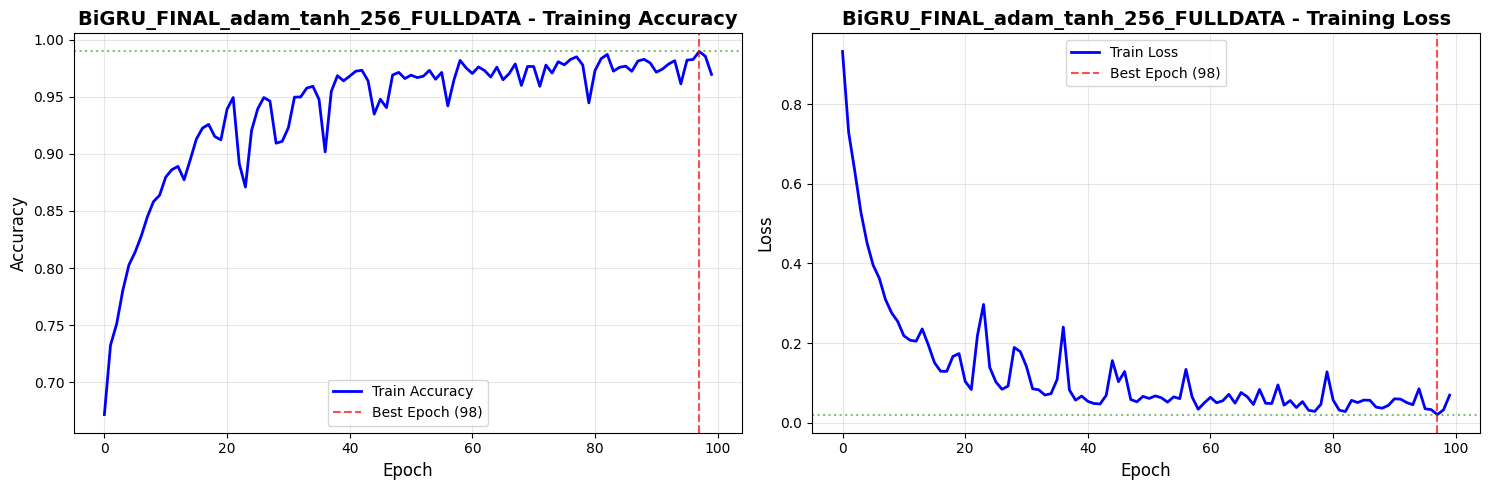

✓ Training history plot saved to: BiGRU_FINAL_adam_tanh_256_FULLDATA_training_history.png


epoch/accuracy,▁▂▃▅▆▆▇▆▇▅▇▇▇▇███▇▇██▇█████▇▇██▇████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▂▂▃▂▂▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁
best_epoch,98
best_train_acc,0.98953
best_train_loss,0.02023
epoch/accuracy,0.96947
epoch/epoch,99
epoch/learning_rate,0.001
epoch/loss,0.06902



🎉 ALL DONE! FINAL MODEL TRAINING COMPLETE!

📦 Outputs:
   • Best Model: models/BiGRU_FINAL_adam_tanh_256_FULLDATA_best.keras
   • Kaggle Predictions: BiGRU_FINAL_adam_tanh_256_FULLDATA_kaggle_submission.csv
   • Training plot: BiGRU_FINAL_adam_tanh_256_FULLDATA_training_history.png

🏆 FINAL RESULTS:
   Training Samples: 30850
   Best Epoch: 98
   Best Train Accuracy: 0.9895 (98.95%)
   Best Train Loss: 0.0202
   Final Train Accuracy: 0.9695 (96.95%)


In [ ]:
# ====================================================================
# FINAL BiGRU MODEL - TRAIN ON FULL DATA (TRAIN + VAL COMBINED)
# ====================================================================
import uuid

# Model configuration from best hyperparameters
FINAL_MODEL_NAME = "BiGRU_FINAL_adam_tanh_256_FULLDATA"
FINAL_RNN_TYPE = 'BiGRU'
FINAL_OPTIMIZER = 'adam'
FINAL_ACTIVATION = 'tanh'
FINAL_DROPOUT = 0 #0.1, #0.2
FINAL_RNN_UNITS = 256
FINAL_BATCH_NORM = True
FINAL_LEARNING_RATE = 0.001

# Training configuration
FINAL_EPOCHS = 100  # Based on tuning results showing convergence around 40-50 epochs
FINAL_BATCH_SIZE = 64

print("="*80)
print(f"🚀 TRAINING FINAL MODEL: {FINAL_MODEL_NAME}")
print("="*80)
print(f"\n📋 CONFIGURATION:")
print(f"   Architecture: {FINAL_RNN_TYPE}")
print(f"   Optimizer: {FINAL_OPTIMIZER}")
print(f"   Activation: {FINAL_ACTIVATION}")
print(f"   Dropout: {FINAL_DROPOUT}")
print(f"   RNN Units: {FINAL_RNN_UNITS}")
print(f"   Batch Norm: {FINAL_BATCH_NORM}")
print(f"   Learning Rate: {FINAL_LEARNING_RATE}")
print(f"   Epochs: {FINAL_EPOCHS}")
print(f"   Batch Size: {FINAL_BATCH_SIZE}")
print("="*80)

# Combine train and validation data
print("\n🔄 Combining train and validation datasets...")
X_full = np.concatenate([X_tr_embeddings_chunked, X_val_embeddings_chunked], axis=0)
y_full = np.concatenate([y_tr_indexed, y_val_indexed], axis=0)

print(f"✓ Full training set: {X_full.shape[0]} samples")
print(f"   Original train: {X_tr_embeddings_chunked.shape[0]} samples")
print(f"   Original validation: {X_val_embeddings_chunked.shape[0]} samples")

# Create full dataset
full_ds = tf.data.Dataset.from_tensor_slices((X_full, y_full))
full_ds = full_ds.shuffle(buffer_size=10000, seed=SEED).batch(FINAL_BATCH_SIZE).prefetch(AUTOTUNE)

print(f"\n🏗️ Building final {FINAL_RNN_TYPE} model...")

# Build model
final_model = build_rnn_model(
    rnn_type=FINAL_RNN_TYPE,
    rnn_units=FINAL_RNN_UNITS,
    activation=FINAL_ACTIVATION,
    dropout=FINAL_DROPOUT,
    use_batch_norm=FINAL_BATCH_NORM
)

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=FINAL_LEARNING_RATE)

final_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
print("\n📊 Model Architecture:")
final_model.summary()

# Initialize W&B
print("\n🔗 Initializing Weights & Biases tracking...")
RUN_ID = uuid.uuid4().hex[:8]
final_run = wandb.init(
    project=WANDB_PROJECT,
    entity=WANDB_ENTITY,
    name=FINAL_MODEL_NAME,
    config={
        "model_type": "FINAL_PRODUCTION",
        "architecture": FINAL_RNN_TYPE,
        "optimizer": FINAL_OPTIMIZER,
        "learning_rate": FINAL_LEARNING_RATE,
        "activation": FINAL_ACTIVATION,
        "dropout": FINAL_DROPOUT,
        "rnn_units": FINAL_RNN_UNITS,
        "batch_norm": FINAL_BATCH_NORM,
        "epochs": FINAL_EPOCHS,
        "batch_size": FINAL_BATCH_SIZE,
        "training_samples": X_full.shape[0],
        "seed": SEED,
        "class_weights": "balanced",
        "data": "train+validation_combined",
        "run_id": RUN_ID
    },
    reinit=True
)

# Callbacks
checkpoint_path = f'models/{FINAL_MODEL_NAME}_best.keras'
os.makedirs('models', exist_ok=True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='loss',           # Monitor training loss
    save_best_only=True,      # Only save when loss improves
    save_weights_only=False,  # Save full model
    mode='min',               # Minimize loss
    verbose=1
)

wandb_callback = WandbMetricsLogger(log_freq="epoch")

# Train model with class weights
print(f"\n🎯 Training final model on {X_full.shape[0]} samples...")
print(f"   Epochs: {FINAL_EPOCHS}")
print(f"   💡 ModelCheckpoint will save best model (lowest training loss)")
print("="*80)

start_time = time.time()

history = final_model.fit(
    full_ds,
    epochs=FINAL_EPOCHS,
    class_weight=class_weights,
    callbacks=[checkpoint_callback, wandb_callback],
    verbose=1
)

train_time = time.time() - start_time

print("\n" + "="*80)
print("✅ FINAL MODEL TRAINING COMPLETE!")
print("="*80)

# Get final metrics
train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
epochs_trained = len(history.history['accuracy'])

# Find best epoch
best_epoch = np.argmin(history.history['loss']) + 1
best_train_loss = np.min(history.history['loss'])
best_train_acc = history.history['accuracy'][np.argmin(history.history['loss'])]

print(f"\n📈 Training Summary:")
print(f"   Epochs trained: {epochs_trained}")
print(f"   Final train accuracy: {train_acc:.4f}")
print(f"   Final train loss: {train_loss:.4f}")
print(f"   🏆 BEST Epoch: {best_epoch}")
print(f"   🏆 BEST train accuracy: {best_train_acc:.4f}")
print(f"   🏆 BEST train loss: {best_train_loss:.4f}")
print(f"   Training time: {train_time/60:.2f} minutes")
print(f"   Model saved to: {checkpoint_path}")

# Log to W&B
wandb.run.summary["final_train_acc"] = train_acc
wandb.run.summary["final_train_loss"] = train_loss
wandb.run.summary["best_epoch"] = best_epoch
wandb.run.summary["best_train_acc"] = best_train_acc
wandb.run.summary["best_train_loss"] = best_train_loss
wandb.run.summary["training_time_sec"] = train_time

# ====================================================================
# GENERATE PREDICTIONS FOR KAGGLE SUBMISSION
# ====================================================================
print("\n" + "="*80)
print("🔮 GENERATING KAGGLE PREDICTIONS")
print("="*80)

# Load best model
print(f"\n📂 Loading BEST model from: {checkpoint_path}")
print(f"   (This is the model from epoch {best_epoch} with lowest training loss)")
best_final_model = tf.keras.models.load_model(checkpoint_path)

# Generate predictions on test set
print(f"\n🔮 Generating predictions on test set ({X_test_embeddings_chunked.shape[0]} samples)...")
test_predictions = best_final_model.predict(test_ds_chunked, verbose=1)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Save predictions for Kaggle
predictions_file = f'{FINAL_MODEL_NAME}_kaggle_submission.csv'
test_df = pd.DataFrame({
    'id': range(len(test_pred_classes)),  # Add ID column if needed by Kaggle
    'prediction': test_pred_classes,
    'confidence': np.max(test_predictions, axis=1)
})
test_df.to_csv(predictions_file, index=False)
print(f"✓ Predictions saved to: {predictions_file}")

# ====================================================================
# PLOT TRAINING HISTORY
# ====================================================================
print("\n📊 Creating training history plots...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, color='blue')
axes[0].axvline(x=best_epoch-1, color='red', linestyle='--', alpha=0.7, 
                label=f'Best Epoch ({best_epoch})')
axes[0].axhline(y=best_train_acc, color='green', linestyle=':', alpha=0.5)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title(f'{FINAL_MODEL_NAME} - Training Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2, color='blue')
axes[1].axvline(x=best_epoch-1, color='red', linestyle='--', alpha=0.7, 
                label=f'Best Epoch ({best_epoch})')
axes[1].axhline(y=best_train_loss, color='green', linestyle=':', alpha=0.5)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title(f'{FINAL_MODEL_NAME} - Training Loss', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plot_filename = f'{FINAL_MODEL_NAME}_training_history.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Training history plot saved to: {plot_filename}")

# Finish W&B run
wandb.finish()

print("\n" + "="*80)
print("🎉 ALL DONE! FINAL MODEL TRAINING COMPLETE!")
print("="*80)
print(f"\n📦 Outputs:")
print(f"   • Best Model: {checkpoint_path}")
print(f"   • Kaggle Predictions: {predictions_file}")
print(f"   • Training plot: {plot_filename}")
print(f"\n🏆 FINAL RESULTS:")
print(f"   Training Samples: {X_full.shape[0]}")
print(f"   Best Epoch: {best_epoch}")
print(f"   Best Train Accuracy: {best_train_acc:.4f} ({best_train_acc*100:.2f}%)")
print(f"   Best Train Loss: {best_train_loss:.4f}")
print(f"   Final Train Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print("="*80)

In [47]:
# Quick fix: Konverter eksisterende submission til korrekt format
old_file = 'BiGRU_FINAL_adam_tanh_256_FULLDATA_kaggle_submission.csv'
new_file = 'BiGRU_FINAL_adam_tanh_256_FULLDATA_kaggle_submission_CORRECTED.csv'

# Læs eksisterende fil
df = pd.read_csv(old_file)

# Lav korrekt format
submission_df = pd.DataFrame({
    'Id': df['id'],
    'Predicted': df['prediction']
})

# Gem i korrekt format
submission_df.to_csv(new_file, index=False)
print(f"✅ Created Kaggle-compatible submission: {new_file}")
print(f"\nFirst 5 rows:")
print(submission_df.head())

✅ Created Kaggle-compatible submission: BiGRU_FINAL_adam_tanh_256_FULLDATA_kaggle_submission_CORRECTED.csv

First 5 rows:
   Id  Predicted
0   0          4
1   1          4
2   2          4
3   3          4
4   4          4


In [44]:
# Build final model with best hyperparameters
print("="*70)
print("🏗️  BUILDING FINAL MODEL WITH BEST HYPERPARAMETERS")
print("="*70)

final_model = build_rnn_model(
    rnn_type=best_config['rnn_type'],
    rnn_units=best_config['rnn_units'],
    activation=best_config['activation'],
    dropout=best_config['dropout'],
    use_batch_norm=best_config['batch_norm']
)

# Compile model
optimizer_instance = None
if best_config['optimizer'] == 'adam':
    optimizer_instance = tf.keras.optimizers.Adam(learning_rate=best_config['learning_rate'])
elif best_config['optimizer'] == 'rmsprop':
    optimizer_instance = tf.keras.optimizers.RMSprop(
        learning_rate=best_config['learning_rate'],
        momentum=best_config['momentum']
    )
elif best_config['optimizer'] == 'sgd':
    optimizer_instance = tf.keras.optimizers.SGD(
        learning_rate=best_config['learning_rate'],
        momentum=best_config['momentum']
    )

final_model.compile(
    optimizer=optimizer_instance,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\n✅ Final Model Architecture:")
print(f"   RNN Type: {best_config['rnn_type']}")
print(f"   RNN Units: {best_config['rnn_units']}")
print(f"   Optimizer: {best_config['optimizer']}")
print(f"   Learning Rate: {best_config['learning_rate']}")
print(f"   Momentum: {best_config['momentum']}")
print(f"   Activation: {best_config['activation']}")
print(f"   Dropout: {best_config['dropout']}")
print(f"   Batch Norm: {best_config['batch_norm']}")

final_model.summary()

🏗️  BUILDING FINAL MODEL WITH BEST HYPERPARAMETERS


NameError: name 'best_config' is not defined

In [40]:
# 🔍 DIAGNOSTIK: Tjek label mapping
print("="*80)
print("🔍 DIAGNOSTIK: Tjek label mapping")
print("="*80)

# Tjek original training labels
print("\n📊 Original training labels (y_train):")
print(f"   Unique values: {np.unique(y_train)}")
print(f"   Value counts: {np.bincount(y_train.flatten())}")

# Tjek indexed labels (hvad modellen er trænet på)
print("\n📊 Indexed training labels (y_tr_indexed):")
print(f"   Unique values: {np.unique(y_tr_indexed)}")
print(f"   Value counts: {np.bincount(y_tr_indexed)}")

# Tjek predictions
print("\n📊 Model predictions (test_pred_classes):")
print(f"   Unique predicted values: {np.unique(test_pred_classes)}")
print(f"   Prediction distribution:")
for cls in np.unique(test_pred_classes):
    count = np.sum(test_pred_classes == cls)
    print(f"      Class {cls}: {count} samples ({count/len(test_pred_classes)*100:.1f}%)")

# Tjek submission fil
print("\n📊 Submission file check:")
print(f"   File: {new_file}")
print(submission_df['Predicted'].value_counts().sort_index())

# Sammenlign med reference fil
print("\n📊 Reference file (y_test_hat.csv):")
ref_df = pd.read_csv('../../y_test_hat.csv')
print(ref_df['Predicted'].value_counts().sort_index())
print(f"\n🔍 Reference predictions range: {ref_df['Predicted'].min()} to {ref_df['Predicted'].max()}")
print(f"🔍 Your predictions range: {submission_df['Predicted'].min()} to {submission_df['Predicted'].max()}")

print("\n" + "="*80)

🔍 DIAGNOSTIK: Tjek label mapping

📊 Original training labels (y_train):
   Unique values: [1 2 3 4 5]
   Value counts: [    0   985  1346  3496  7050 17973]

📊 Indexed training labels (y_tr_indexed):
   Unique values: [0 1 2 3 4]
   Value counts: [  788  1077  2797  5640 14378]

📊 Model predictions (test_pred_classes):
   Unique predicted values: [0 1 2 3 4]
   Prediction distribution:
      Class 0: 120 samples (3.5%)
      Class 1: 120 samples (3.5%)
      Class 2: 442 samples (12.9%)
      Class 3: 708 samples (20.7%)
      Class 4: 2038 samples (59.5%)

📊 Submission file check:
   File: BiGRU_FINAL_adam_tanh_256_FULLDATA_kaggle_submission_CORRECTED.csv
Predicted
0     120
1     120
2     442
3     708
4    2038
Name: count, dtype: int64

📊 Reference file (y_test_hat.csv):
Predicted
3      14
4     182
5    3232
Name: count, dtype: int64

🔍 Reference predictions range: 3 to 5
🔍 Your predictions range: 0 to 4



In [48]:
# 🔧 FIX: Shift predictions back to original label space
print("="*80)
print("🔧 FIXING LABEL MAPPING")
print("="*80)

# Læs original submission
df_wrong = pd.read_csv('BiGRU_FINAL_adam_tanh_256_FULLDATA_kaggle_submission_CORRECTED.csv')

print("\n❌ BEFORE fix:")
print(f"   Prediction range: {df_wrong['Predicted'].min()} to {df_wrong['Predicted'].max()}")
print(f"   Distribution:\n{df_wrong['Predicted'].value_counts().sort_index()}")

# Shift predictions +1 (0→1, 1→2, 2→3, 3→4, 4→5)
df_fixed = pd.DataFrame({
    'Id': df_wrong['Id'],
    'Predicted': df_wrong['Predicted'] + 1  # SHIFT UP BY 1!
})

# Gem korrekt fil
fixed_file = 'BiGRU_FINAL_adam_tanh_256_FULLDATA_FIXED_LABELS.csv'
df_fixed.to_csv(fixed_file, index=False)

print("\n✅ AFTER fix:")
print(f"   Prediction range: {df_fixed['Predicted'].min()} to {df_fixed['Predicted'].max()}")
print(f"   Distribution:\n{df_fixed['Predicted'].value_counts().sort_index()}")

print(f"\n📁 Upload this file to Kaggle: {fixed_file}")
print("="*80)

🔧 FIXING LABEL MAPPING

❌ BEFORE fix:
   Prediction range: 0 to 4
   Distribution:
Predicted
0     104
1     149
2     494
3     680
4    2001
Name: count, dtype: int64

✅ AFTER fix:
   Prediction range: 1 to 5
   Distribution:
Predicted
1     104
2     149
3     494
4     680
5    2001
Name: count, dtype: int64

📁 Upload this file to Kaggle: BiGRU_FINAL_adam_tanh_256_FULLDATA_FIXED_LABELS.csv


## Performance documentation

### 3.1 TrainningCurves (loss/accuracy/AUC)

Vi plotter den **sidst trænede models** historik (her: ViT). Du kan let skifte til `history_cnn` eller kombinere i ét plot.

In [ ]:
def plot_history(hist, title="Training curves"):
    hist = hist.history
    plt.figure(figsize=(6,4))
    plt.plot(hist.get("loss",[]), label="loss")
    plt.plot(hist.get("val_loss",[]), label="val_loss")
    plt.title(title + " — loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

    if "accuracy" in hist or "acc" in hist:
        acc_key = "accuracy" if "accuracy" in hist else "acc"
        val_acc_key = "val_accuracy" if "val_accuracy" in hist else "val_acc"
        plt.figure(figsize=(6,4))
        plt.plot(hist.get(acc_key,[]), label=acc_key)
        plt.plot(hist.get(val_acc_key,[]), label=val_acc_key)
        plt.title(title + " — accuracy")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.show()

    if "auc" in hist:
        plt.figure(figsize=(6,4))
        plt.plot(hist.get("auc",[]), label="auc")
        plt.plot(hist.get("val_auc",[]), label="val_auc")
        plt.title(title + " — AUC")
        plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.legend(); plt.show()

# Plot for CNN (head + finetune)
plot_history(history_cnn, "CNN (frozen backbone)")
plot_history(history_cnn_ft, "CNN (finetuned)")


# create directory for plots in save_dir
os.makedirs(os.path.join(save_dir, "plots"), exist_ok=True)

# after creating all plots, save them to save_dir
for i in plt.get_fignums():
    fig = plt.figure(i)
    fig.savefig(os.path.join(save_dir, f"plots/training_curve_{i}_{WANDB_ID}.png"))


## 4.1) Prepare final re-fit

In [ ]:
print('preparing final refit')

# Train* DataSet (val + train)
#train_star = train_ds.concatenate(val_ds).shuffle(
#    buffer_size=2048, seed=SEED, reshuffle_each_iteration=True
#)
	
train_star = train_ds.concatenate(val_ds)

# update W&B for refit
final_callbacks = [
    WandbMetricsLogger(log_freq="epoch"),
    WandbModelCheckpoint(
        filepath=os.path.join(save_dir, "final_refit.weights.h5"),
        monitor="auc",    # ingen val-data, så brug trænings-AUC
        mode="max",
        save_weights_only=True,
        save_best_only=True,
        save_freq="epoch",
    ),
]

wandb.log({"phase": "final_refit"})

final_model = finetune_model

## 4.2) Final re-fit on train* (train+val)

In [ ]:
print('[FINAL REFIT]')

# Reuse best model weights and ReFit on train*
history_final = final_model.fit(
	train_star,
	epochs=best_ft_epoch,
	verbose=1,
	callbacks=final_callbacks
)

In [ ]:
final_model.summary()

In [ ]:
# Save final refitted model
final_model.save(os.path.join(save_dir, f"model_final_refit_{WANDB_ID}.keras"))

## 4.3) Log to W&B

In [ ]:
# W&B Artifact
artifact = wandb.Artifact(
    name=f"{MODEL_NAME}_seed{SEED}_{WANDB_ID}_final_refit",
    type="model",
    metadata={
        "model_name": MODEL_NAME,
        "img_size": IMG_SIZE,
        "seed": SEED,
        "finetune_lr": LR * 0.1,
        "refit_epochs_total": int(best_ft_epoch),
        "phase": "final_refit",
        "source_run_id": WANDB_ID,
    },
)

artifact.add_file(os.path.join(save_dir, f"model_final_refit_{WANDB_ID}.keras"))

artifact.add_file(save_dir + "/final_refit.weights.h5")
wandb.log_artifact(artifact)

# W&B Metrics 📊 for final refit
final_metrics = {
    "final_refit_best_epoch": np.argmax(history_final.history["auc"]) + 1,
    "final_refit_last_epoch": len(history_final.history["loss"]),
    "final_refit_best_auc": float(np.max(history_final.history["auc"])),
    "final_refit_last_auc": float(history_final.history["auc"][-1]),
    "final_refit_best_loss": float(np.min(history_final.history["loss"])),
    "final_refit_last_loss": float(history_final.history["loss"][-1]),
}

wandb.log(final_metrics)

print(f"[FINAL REFIT] Done ✅")
print(f"[FINAL REFIT] ✅ Model saved: {save_dir}")
print(f"[FINAL REFIT] 🪄 W&B artifact: {artifact.name}")

#finish wandb
wandb.finish()

### 5) Export CSV with probabilities (on test)

In [ ]:
# Generate submission csv using test_ds
y_test_hat = final_model.predict(test_ds, verbose=1)
ytest_hat = pd.DataFrame({
    'Id': list(range(len(y_test_hat))),
    'Predicted': y_test_hat.reshape(-1,),
})

# create directory for csv export inside save_dir
os.makedirs(os.path.join(save_dir, "csv"), exist_ok=True)
ytest_hat.to_csv(f'{save_dir}/csv/ytest_hat_{WANDB_ID}.csv', index=False)

### 6) Find optimal accuracy threshold based on validation

In [ ]:
# === A) Find optimal threshold på val_ds (max accuracy) ===
import numpy as np
from sklearn.metrics import accuracy_score

print("[THR] Finder optimal threshold på val_ds (baseret på accuracy)")

# 1) Hent y_true og p_hat fra val_ds
y_val_true = []
for _, y in val_ds:
    y_val_true.append(y.numpy())
y_val_true = np.concatenate(y_val_true).astype(int)

# Keras .predict giver sandsynligheder (antager sigmoid i sidste lag)
y_val_prob = final_model.predict(val_ds, verbose=0).reshape(-1)

# 2) Grid-scan thresholds i [0.0, 1.0]
thr_grid = np.linspace(0.0, 1.0, 1001)  # opløsning 0.001
accs = []

for thr in thr_grid:
    y_val_pred = (y_val_prob >= thr).astype(int)
    accs.append(accuracy_score(y_val_true, y_val_pred))

accs = np.array(accs)
best_idx = int(np.argmax(accs))
best_thr = float(thr_grid[best_idx])
best_acc = float(accs[best_idx])

print(f"[THR] Bedste threshold = {best_thr:.3f} med val-accuracy = {best_acc:.4f}")

# (valgfrit) log til W&B
try:
    wandb.log({"threshold/best": best_thr, "threshold/val_accuracy": best_acc})
except Exception as e:
    print("[THR] W&B log skipped:", e)


In [ ]:
# calculate best threshold plot based on Cross validation k-fold 10, with 0.8 train and 0.2 val splits

# setup new datasplit from original train data
X_tr_final, X_val_final, y_tr_final, y_val_final = train_test_split(
	Xtrain, ytrain, test_size=0.2, random_state=42, stratify=ytrain
)

# use cross validation to find best threshold with 10 folds
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# for each fold find best threshold
best_thresholds = []
for train_index, val_index in kf.split(X_tr_final):
	X_tr_fold, X_val_fold = X_tr_final[train_index], X_tr_final[val_index]
	y_tr_fold, y_val_fold = y_tr_final[train_index], y_tr_final[val_index]

	# create datasets
	train_ds_fold = make_train_ds(X_tr_fold, y_tr_fold)
	val_ds_fold = make_eval_ds(X_val_fold, y_val_fold)

	# predict on val_ds_fold
	y_val_prob_fold = final_model.predict(val_ds_fold, verbose=0).reshape(-1)

	# get true labels
	y_val_true_fold = []
	for _, y in val_ds_fold:
		y_val_true_fold.append(y.numpy())
	y_val_true_fold = np.concatenate(y_val_true_fold).astype(int)

	# grid scan thresholds
	thr_grid = np.linspace(0.0, 1.0, 1001)
	accs = []

	for thr in thr_grid:
		y_val_pred_fold = (y_val_prob_fold >= thr).astype(int)
		accs.append(accuracy_score(y_val_true_fold, y_val_pred_fold))

	accs = np.array(accs)
	best_idx = int(np.argmax(accs))
	best_thr = float(thr_grid[best_idx])
	best_thresholds.append(best_thr)

mean_best_thr = np.mean(best_thresholds)
std_best_thr = np.std(best_thresholds)

print(f"[THR CV] Mean best threshold from CV = {mean_best_thr:.3f} ± {std_best_thr:.3f}")

In [ ]:
# === B) Generér 0/1 Kaggle-CSV fra test_ds ved brug af best_thr ===
import os
import pandas as pd

assert "best_thr" in globals(), "Kør først threshold-cellen (A), så 'best_thr' findes."

# 1) Hent P(y=1) på test
y_test_prob = final_model.predict(test_ds, verbose=1).reshape(-1)

# 2) Threshold til 0/1
y_test_label = (y_test_prob >= best_thr).astype(int)

# 3) Gem CSV
os.makedirs(os.path.join(save_dir, "csv"), exist_ok=True)
csv_path = os.path.join(save_dir, "csv", f"submission_threshold_{best_thr:.3f}_{WANDB_ID}.csv")
pd.DataFrame({"Id": np.arange(len(y_test_label)), "Predicted": y_test_label}).to_csv(csv_path, index=False)

print(f"[SUBMIT] Skrev 0/1-label CSV til:\n{csv_path}")

# (valgfrit) log filen som W&B-artifact
try:
    art = wandb.Artifact(
        name=f"{MODEL_NAME}_seed{SEED}_{WANDB_ID}_submission_thr",
        type="submission",
        metadata={"threshold": best_thr, "source_run_id": WANDB_ID}
    )
    art.add_file(csv_path)
    wandb.log_artifact(art)
except Exception as e:
    print("[SUBMIT] W&B artifact skip:", e)
